I recently [read](https://austinrochford.com/reading-log.html) [_Who's Counting? Uniting Numbers and Narratives with Stories from Pop Culture, Puzzles, Politics, and More_](https://rowman.com/ISBN/9781633888128/Who's-Counting-Uniting-Numbers-and-Narratives-with-Stories-from-Pop-Culture-Puzzles-Politics-and-More) by John Allen Paulos.  In the Chapter 6 section titled "Voting Blocs: Red States, Blue State, and a Model for Thoughtless Voting," Paulos mentions an interesting paper by Joshua Epstein, [_Learning To Be Thoughtless:
Social Norms And Individual Computation_](https://www.brookings.edu/wp-content/uploads/2016/06/thoughtless.pdf).  In this paper, Epstein proposes a simple but compelling [agent-based model](https://en.wikipedia.org/wiki/Agent-based_model) for how [social norms](https://en.wikipedia.org/wiki/Social_norm) evolve in a community.  This model is interesting because it captures two fundametal forces that motivate human behavior quite elegantly:

1. the social influence the behavior of others exerts on our own, and
2. laziness.

Paulos uses Epstein's model as a potential explanation for the increasing polarization of American Politics, which, while plausible, is not the focus of this post.  After following the citation to Epstein's paper, I thought it would be fun and instructive to implement this model in Python and reproduce the main results of the paper.

Epstien's paper uses the decision to drive on the left- or right-hand side of the road as the social norm under analysis.  For the purpose of this post, we will use a boolean flag `norm` to indicate whether or not an agent conforms to the social norm (defined, for instance, by driving on the right-hand side of the road in the United States) or does not (driving on the left-hand side of the road in the United States).

Epstein names his agents "lazy statisticans."  These lazy statisticians determine whether or not they follow the social norm based on the norm-following behavior of the other agents in their vicinity.  The size of the neighborhood that influences a statistician's behavior is their `radius`.  With this terminology, we can begin to implement lazy statisticians in Python.  Throughout this post we use [Mesa](https://mesa.readthedocs.io/en/latest/), an agent-based modeling framework that

> allows users to quickly create agent-based models using built-in core components (such as spatial grids and agent schedulers) or customized implementations; visualize them using a browser-based interface; and analyze their results using Python’s data analysis tools.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
from fastprogress.fastprogress import progress_bar
from matplotlib import pyplot as plt
import mesa

In [3]:
import seaborn as sns

In [4]:
plt.rc("figure", figsize=(8, 6))
plt.rc("font", size=14)
sns.set(color_codes=True)

CMAP = "viridis"

Each lazy statistician is a Mesa [`Agent`](https://mesa.readthedocs.io/en/latest/apis/init.html#mesa.Agent).  Following the paper, if no initial value for `norm` is past, we choose one with a coin flip, and if no initial `radius` is passed, we choose one uniformly between one and fitfy.

In [5]:
class LazyStatistician(mesa.Agent):
    def __init__(self, unique_id, model, norm=None, radius=None, tol=0.05):
        super().__init__(unique_id, model)
        
        self.norm = self.random.choice([False, True]) if norm is None else norm
        self.radius = self.random.randint(1, 51) if radius is None else radius
        self.tol = tol

When a lazy statistician updates their norm-following behavior, they do so based on the proportion of norm-following agents in their vicinity as determined by their radius (optionally offset by `Δ`).

In [6]:
class LazyStatistician(LazyStatistician):
    def get_norm_pct(self, *, Δ=0):
        radius = self.radius + Δ
        nhbrs = self.model.grid.iter_neighbors(self.pos, moore=True, radius=radius)

        return sum(nhbr.norm for nhbr in nhbrs) / (2 * radius + 1)

When a lazy statistician updates their norm-following behavior, they do so in two steps.  First they update the radius of neighboring agents that influence them, then they update their norm.

When updating their radius, a lazy statistician first compares the proportion of norm-followers in their current neighborhood, defined by their radius, to the proportion of norm-followers in the neighborhood defined by `radius + 1`.  If these not close (for the purposes of this post, we mostly follow the guideline of the paper and define "close" to be within 5% of each other), the lazy statistician increases their radius by one, since more data is better.  If they are close, the lazy statistician compares the proportion of norm-followers in their current neighborhood to the proportion of norm-followers in the neighborhood by `radius - 1`.  If these are close, the lazy statisician decreases their radius by one (due to their laziness).

In [7]:
class LazyStatistician(LazyStatistician):
    def update_radius(self):
        norm_pct = self.get_norm_pct()
        more_pct = self.get_norm_pct(Δ=1)
        
        if abs(norm_pct - more_pct) > self.tol:
            self.radius += 1
        elif self.radius > 1:
            less_pct = self.get_norm_pct(Δ=-1)
            
            if abs(norm_pct - less_pct) <= self.tol:
                self.radius -= 1

After updating their radius, a lazy statistician updates their norm to agree with the majority of the agents in their neighborhood (including themselves).  Note that including themsevles means that there are an odd number of agents (`2 * radius + 1`) agents in their neighborhood, so their will never be an ambiguous case where exactly 50% of agents in the neighborhood are norm-followers.

In [8]:
class LazyStatistician(LazyStatistician):
    def update_norm(self):
        self.norm = self.get_norm_pct() > 0.5

    def step(self):
        self.update_radius()
        self.update_norm()

If there are $N$ agents, at each time step $N$ agents are drawn randomly with replacement and their status is updated as described above.  Mesa does not include this sort of [bootstrap](https://en.wikipedia.org/wiki/Bootstrapping_%28statistics%29) scheduler out-of-the-box, but it is simple to implement.

In [9]:
class BootstrapActivation(mesa.time.BaseScheduler):
    def step(self):
        for _ in range(self.get_agent_count()):
            self.model.random.choice(self.agents).step()
            
        self.steps += 1
        self.time += 1

With `LazyStatistician` and `BoostrapActivation` defined, we are ready to implement our model.

In [10]:
class ThoughtlessModel(mesa.Model):
    def __init__(self, n_agent, norm=None, seed=None,
                 agent_cls=LazyStatistician, **agent_kwargs):
        self.grid = mesa.space.SingleGrid(n_agent, 1, torus=True)
        self.schedule = BootstrapActivation(self)
        
        for unique_id in range(n_agent):
            agent = agent_cls(unique_id, self, norm=norm, **agent_kwargs)
            
            self.schedule.add(agent)
            self.grid.place_agent(agent, (unique_id, 0))
            
        self.datacollector = mesa.DataCollector(agent_reporters={"norm": "norm", "radius": "radius"})
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

The most important feature of of this model is that the agents are placed on a circle (as indicated by the `torus=True` keyword argument to [`SingleGrid`](https://mesa.readthedocs.io/en/latest/apis/space.html#mesa.space.SingleGrid).)  Another point of note is that the constructor take the agent class as a parameter.  This flexibility will be useful in reconstructing examples from the paper that add noise and/or temporal shocks to the lazy statistician's update rules.

With `ThoughtlessModel` in hand, we can start reproducing Epstein's computational results.  The paper presents six runs of the model, exploring

> stylized facts regarding the evolution of norms: [l]ocal conformity, global diversity, and punctuated equilibria.

## Run 1. Monolithic Social Norm, Individual Computing Dies Out

Following Epstein, for the first simulation we set each lazy statistician's initial `norm` to `False`.  In this case, we anticipate that `norm` should remain `False` for all agents for all time and each agent's `radius` should shrink to the minimum value of one.

We choose a seed value for reproducibility.

In [11]:
SEED = 1234567890

Instead of simulating 190 lazy statisticians as in the paper, we simulate 500.  We find that this yields interesting outcomes in more complex situations far more often (as the seed varies).  As in the paper, we simulate 275 time steps.

In [12]:
N_AGENT = 500
N_STEP = 275

In [13]:
def simulate(model, n_step):
    for _ in progress_bar(range(n_step)):
        model.step()
        
    return model

In [14]:
model_1a = simulate(ThoughtlessModel(N_AGENT, norm=False, seed=SEED), N_STEP)

Visualizing the evolution of each agent's norm and radius over time confirms our expectations.

In [15]:
def plot_results(model, cmap=CMAP, figsize=(16, 6)):
    agent_df = model.datacollector.get_agent_vars_dataframe()
    
    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True,
                             figsize=figsize, gridspec_kw={"width_ratios": (0.85, 1)})
    norm_ax, radius_ax = axes
    
    sns.heatmap(agent_df["norm"].unstack(),
                cmap=cmap, vmin=0, vmax=1, cbar=False,
                ax=norm_ax)
    
    norm_ax.set_xticks([])
    norm_ax.set_xlabel("Agent")
    
    norm_ax.set_yticks([])
    norm_ax.set_ylabel("Step")
    
    norm_ax.set_title("norm")
    
    rhm = sns.heatmap(agent_df["radius"].unstack(),
                     cmap=cmap, vmin=1, vmax=10,
                     ax=radius_ax)
    
    radius_ax.set_xticks([])
    radius_ax.set_xlabel("Agent")
    
    radius_ax.set_yticks([])
    radius_ax.set_ylabel(None)
    
    radius_ax.set_title("radius")

    fig.tight_layout()
    
    return fig, axes

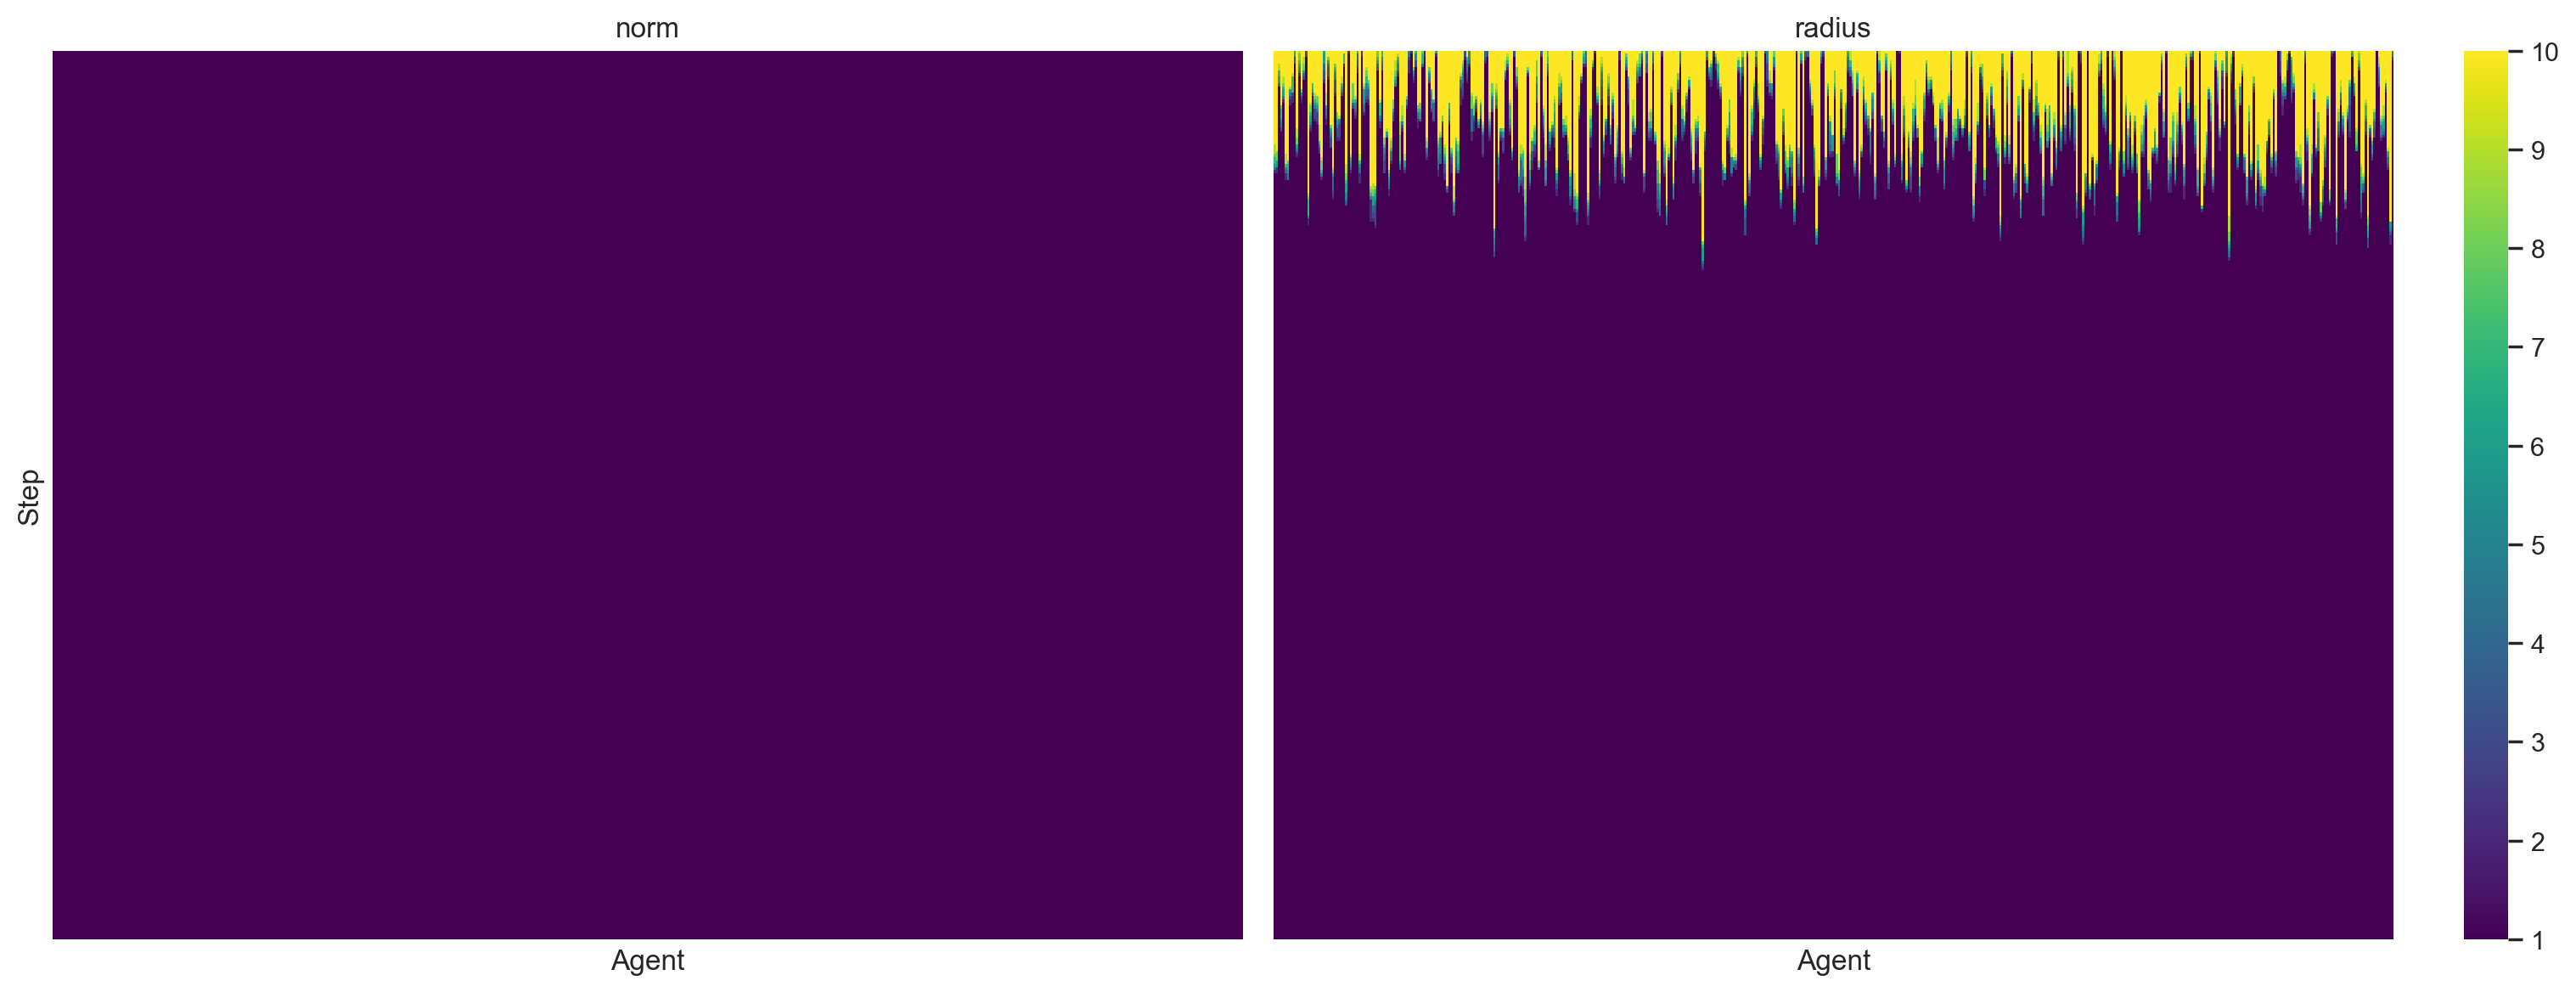

In [16]:
plot_results(model_1a);

Though the paper does show this scenario, we get an analagous result when all of the initial norms are `True`.

In [17]:
model_1b = simulate(ThoughtlessModel(N_AGENT, norm=True, seed=SEED), N_STEP)

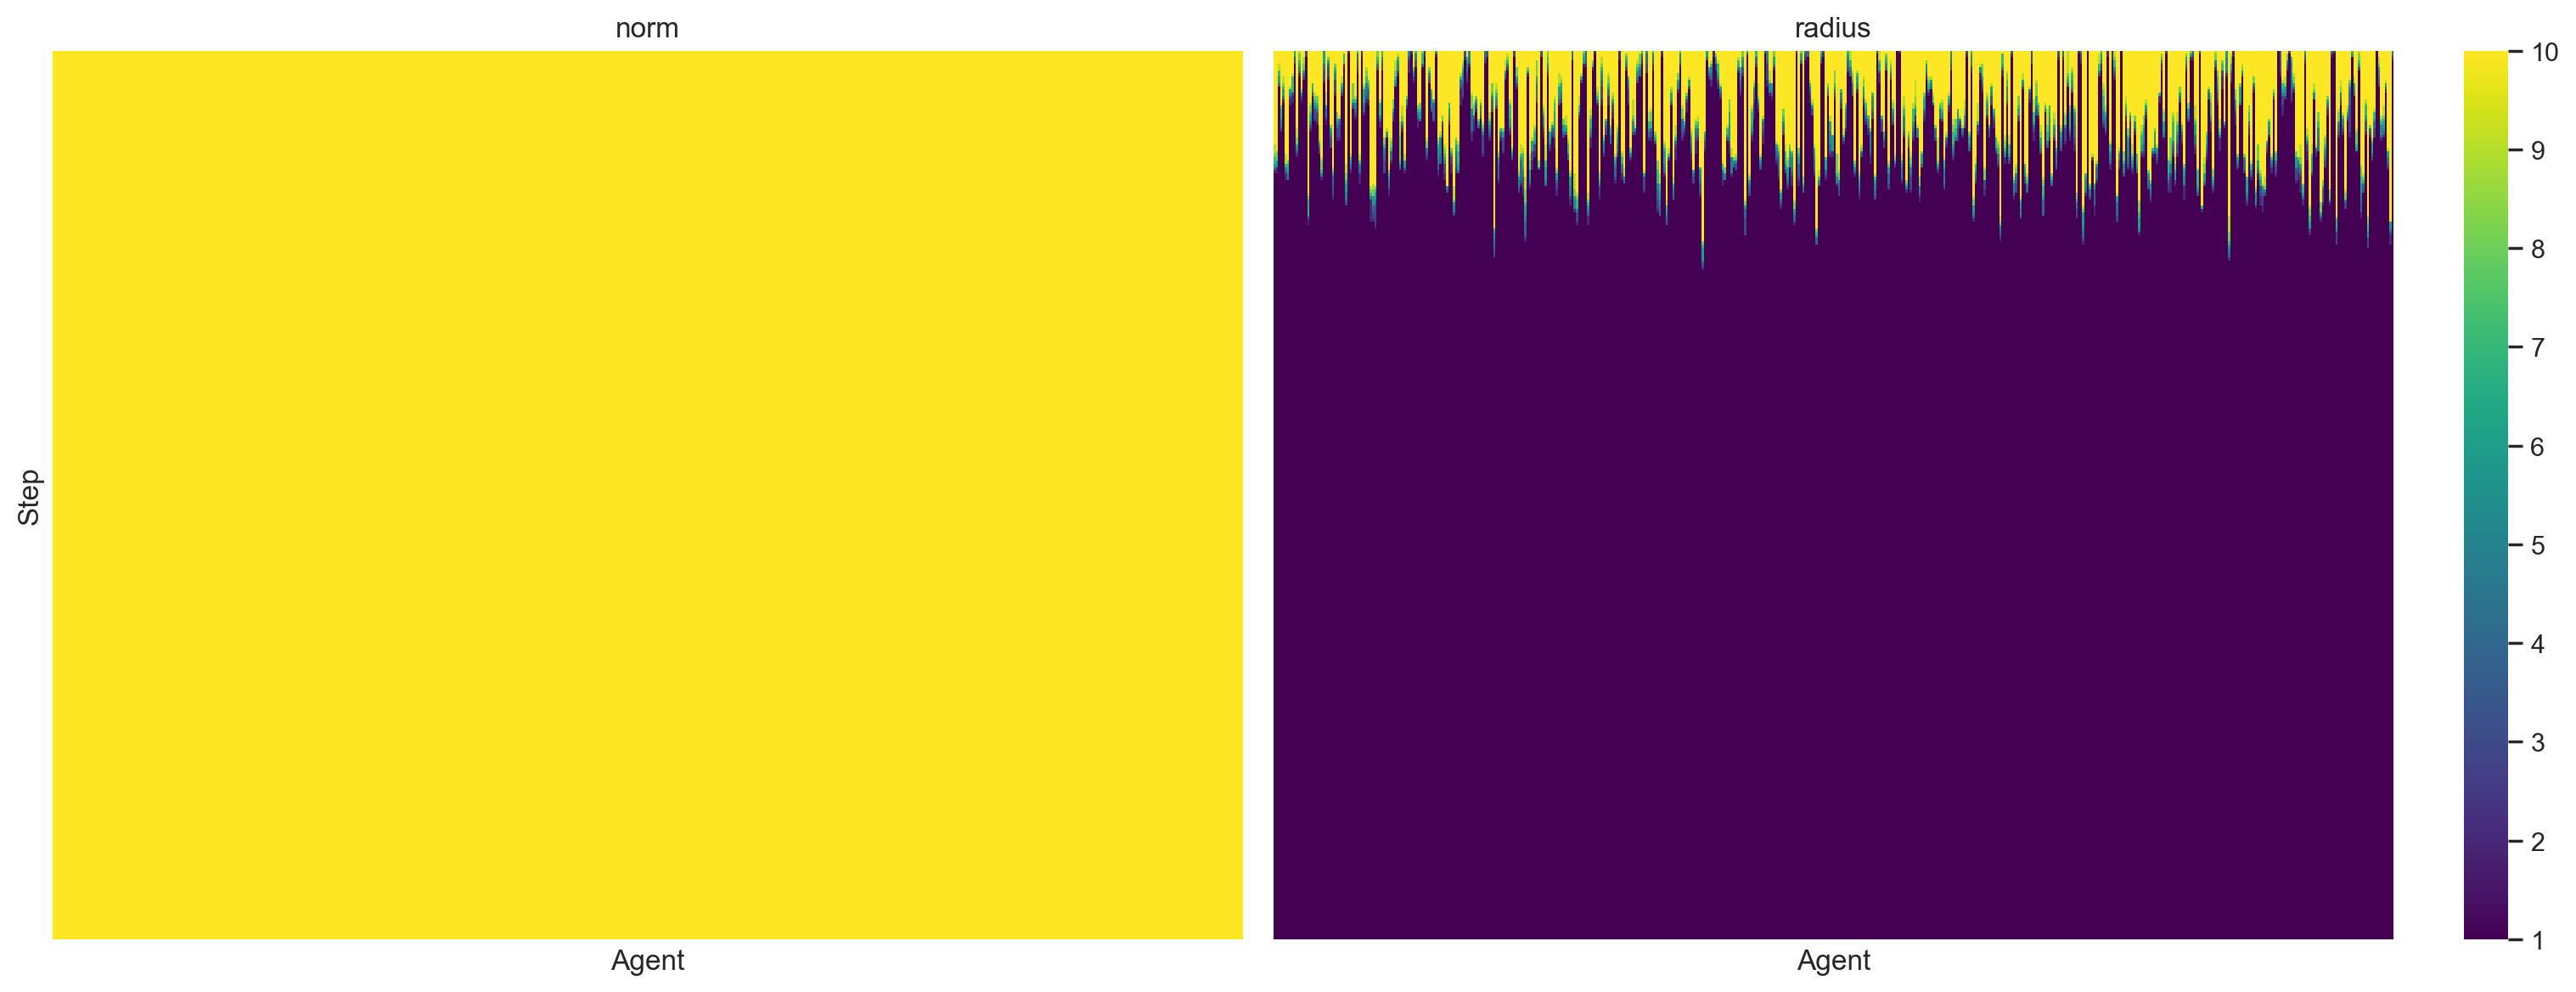

In [18]:
plot_results(model_1b);

In each of these cases, "individual computing dies out" is reflected by the fact that every agent's radius eventually decreases to one, the smallest possible.

## Run 2. Random Initial Norms, Individual Computing At Norm Boundaries

Run one verified our intuition in the basic but unrealistic case of a uniform ("monolithic") initial value of norm.  In run two we explore the more interesting and realistic situation where the initial values of norm are random.

In [19]:
model_2a = simulate(ThoughtlessModel(N_AGENT, seed=SEED), N_STEP)

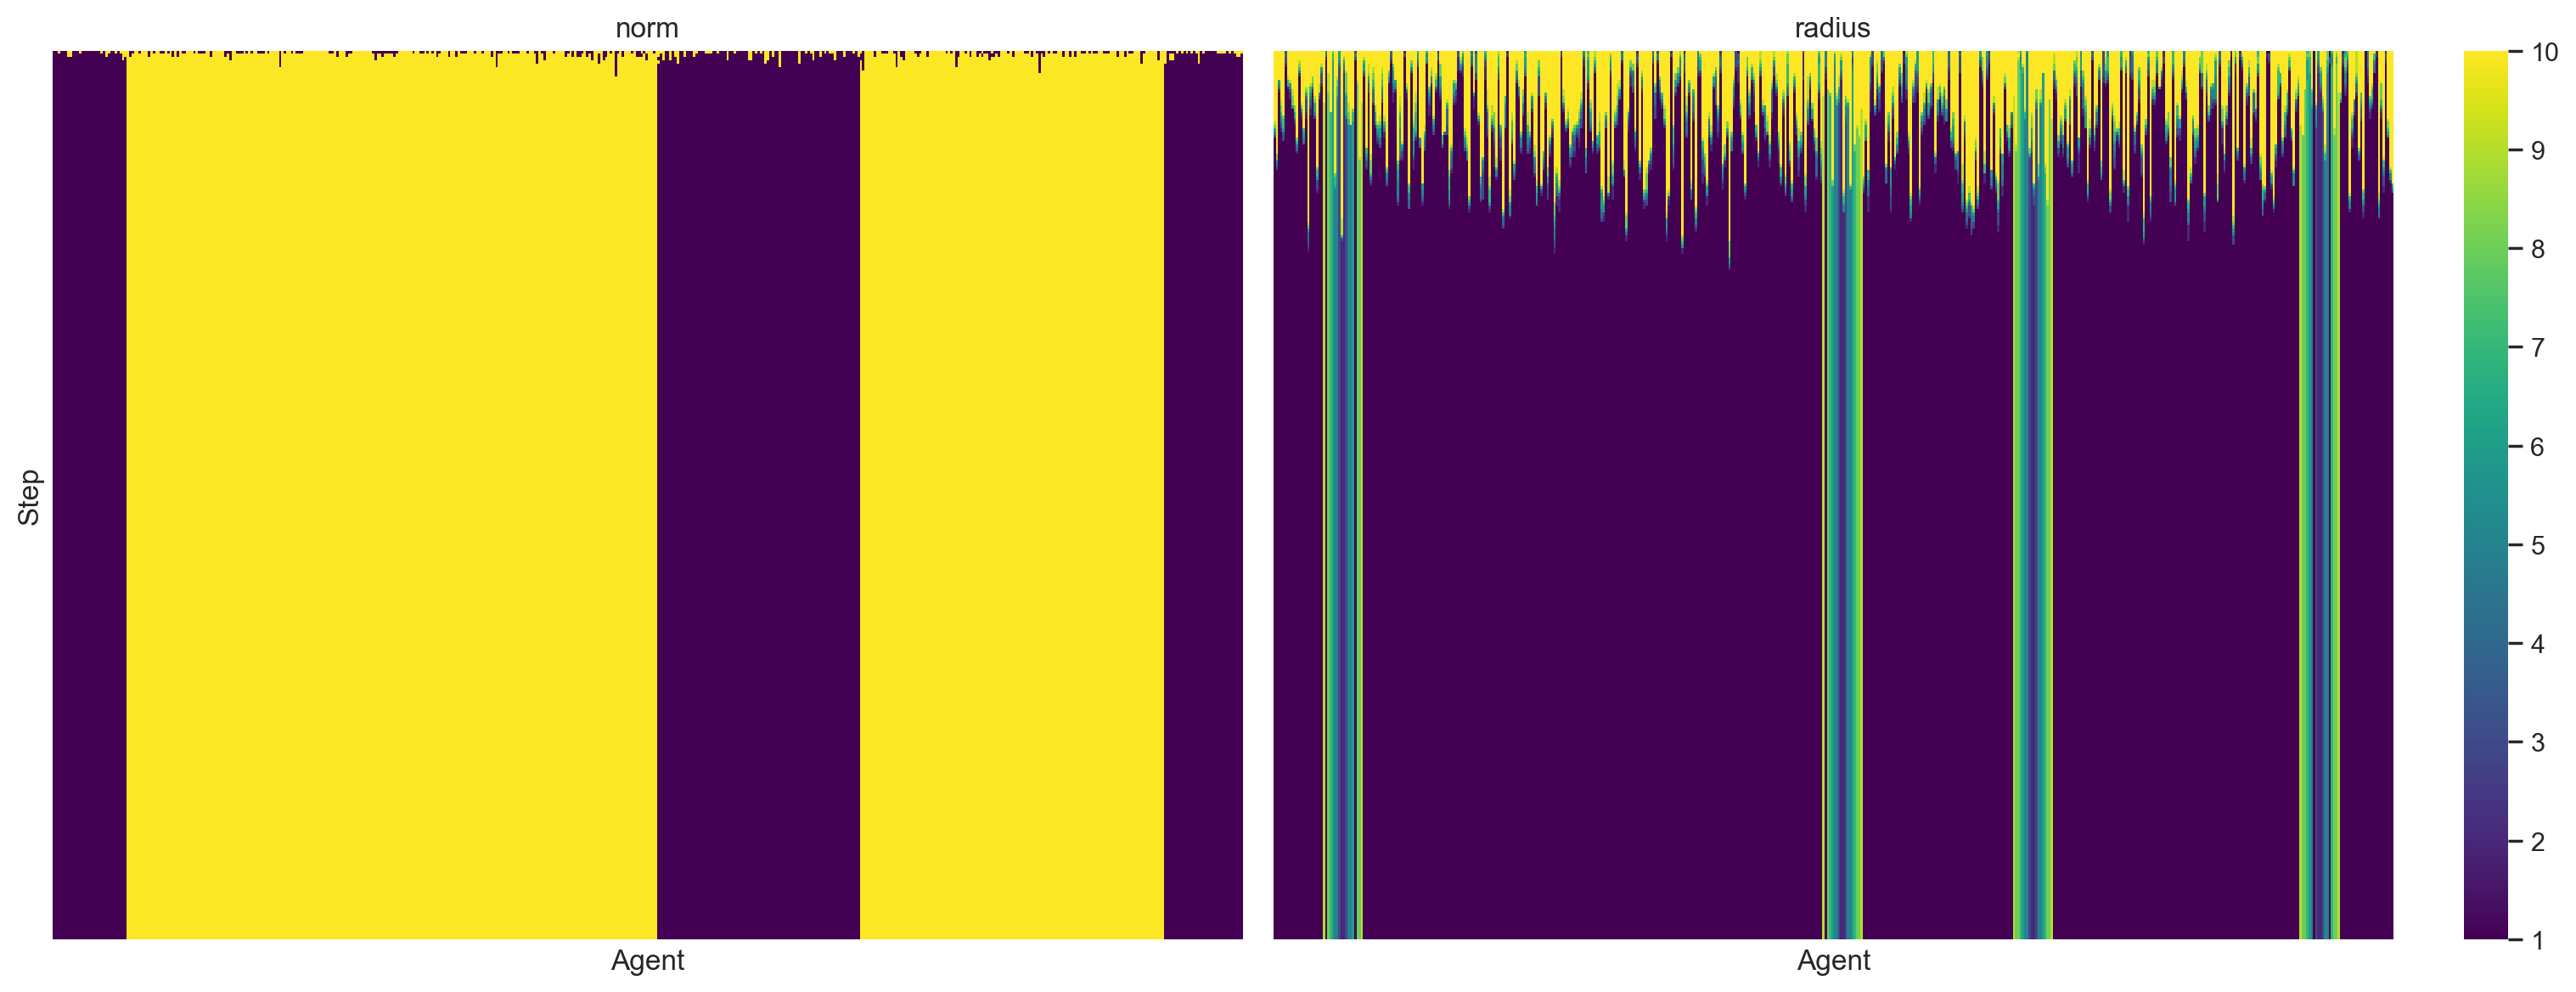

In [20]:
plot_results(model_2a);

We see that there are two disjoint regions where norm is `True` and two where it is `False`.  (Recall that the agents are on a circle so the regions at the left and right ends of this plot are the same from their perspective.)  "Individual computing at norm boundaries" corresponds to the fact that all agents sufficiently far in the interior of the constant-norm regions eventually have radius one, and it is only agents near the borders of these regions that "compute" in the sense of consulting more than their direct neighbors in their norm update decisions.

In order to understand the factors influencing the width of these edges that compute, we reduce the tolerance used when updating an agent's radius from 5% to 2.5%.

In [21]:
model_2b = simulate(ThoughtlessModel(N_AGENT, tol=0.025, seed=SEED), N_STEP)

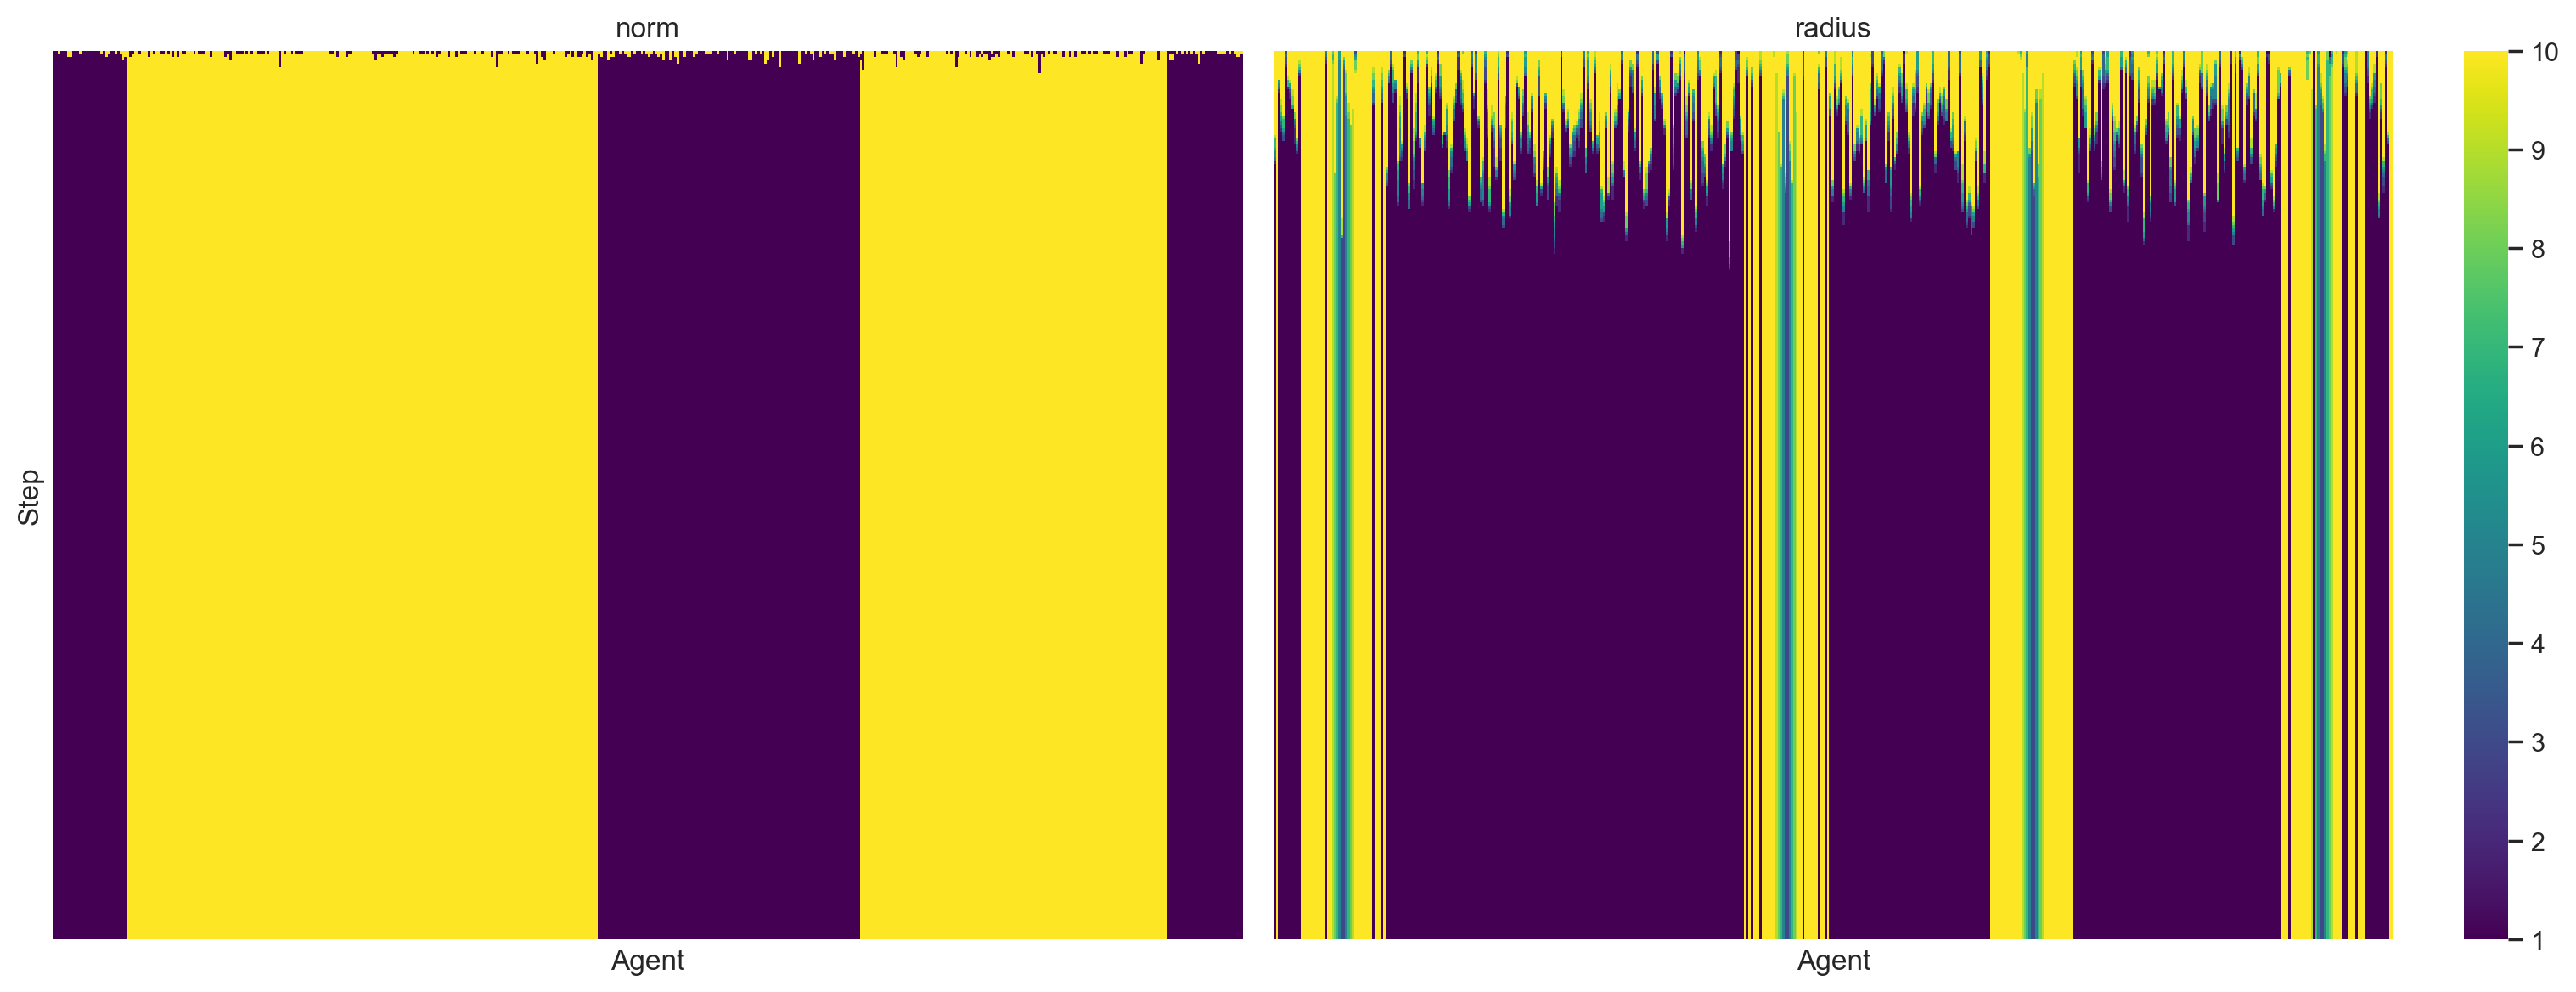

In [22]:
plot_results(model_2b);

We see that a lower tolerance causes an agent to expand their radius more often (remember the agent checks a larger radius before considering a smaller radius) and therefore we end up with more agents with nontrivial radius.  In the opposite direction, doubling the tolerance to 10% causes agents to increase their radius less often and therefore the boundary where computing occurs shrinks.

In [23]:
model_2c = simulate(ThoughtlessModel(N_AGENT, tol=0.1, seed=SEED), N_STEP)

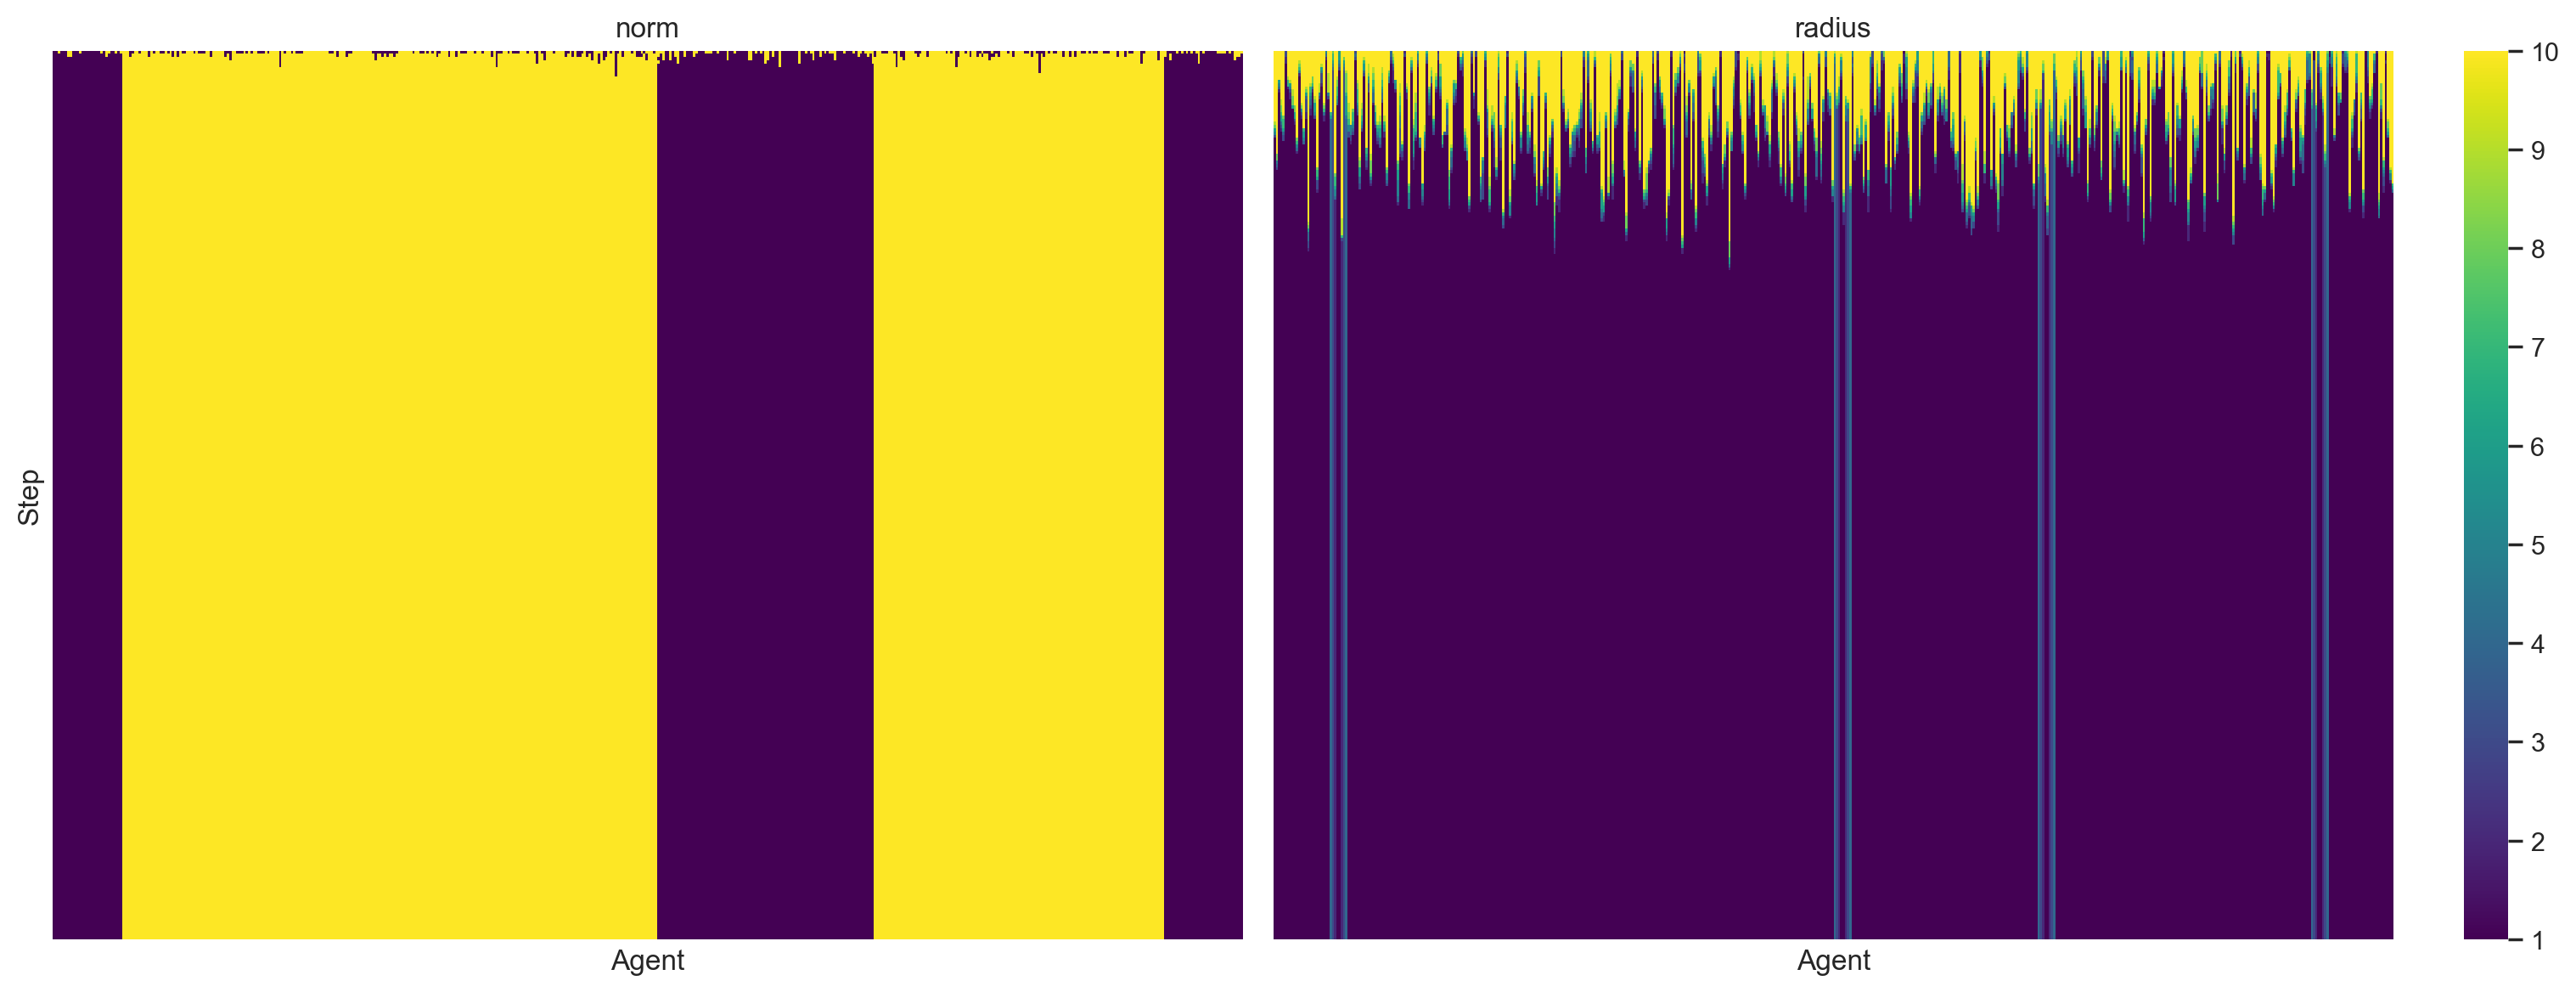

In [24]:
plot_results(model_2c);

## Run 4. Modest Noise Level and Endogenous Neighborhood Norms

For implementation reasons we will replicate run three in the paper last and skip to run four now.  The first two scenarios treated a noiseless case where agents never spontaneously change their norm regardless of the input from their neighbors.  This noiselessness is unrealistic, so we introduce a `NoisyLazyStatistician` subclass of `LazyStatistician` that randomly draws a new norm occasionally according to its `noise` parameter.

In [25]:
class NoisyLazyStatistician(LazyStatistician):
    def __init__(self, unique_id, model, norm=None, radius=None, noise=0):
        super().__init__(unique_id, model, norm=norm, radius=radius)
        
        self.noise = noise
        
    def update_norm(self, noise=None):
        if self.random.random() < (self.noise if noise is None else noise):
            self.norm = self.random.choice([False, True])
        else:
            super().update_norm()

We simulate behavior when agents randomize their norm due to noise 15% of the time and visualize the results below.

In [26]:
model_4 = simulate(
    ThoughtlessModel(N_AGENT, seed=SEED, noise=0.15,
                     agent_cls=NoisyLazyStatistician),
    N_STEP
)

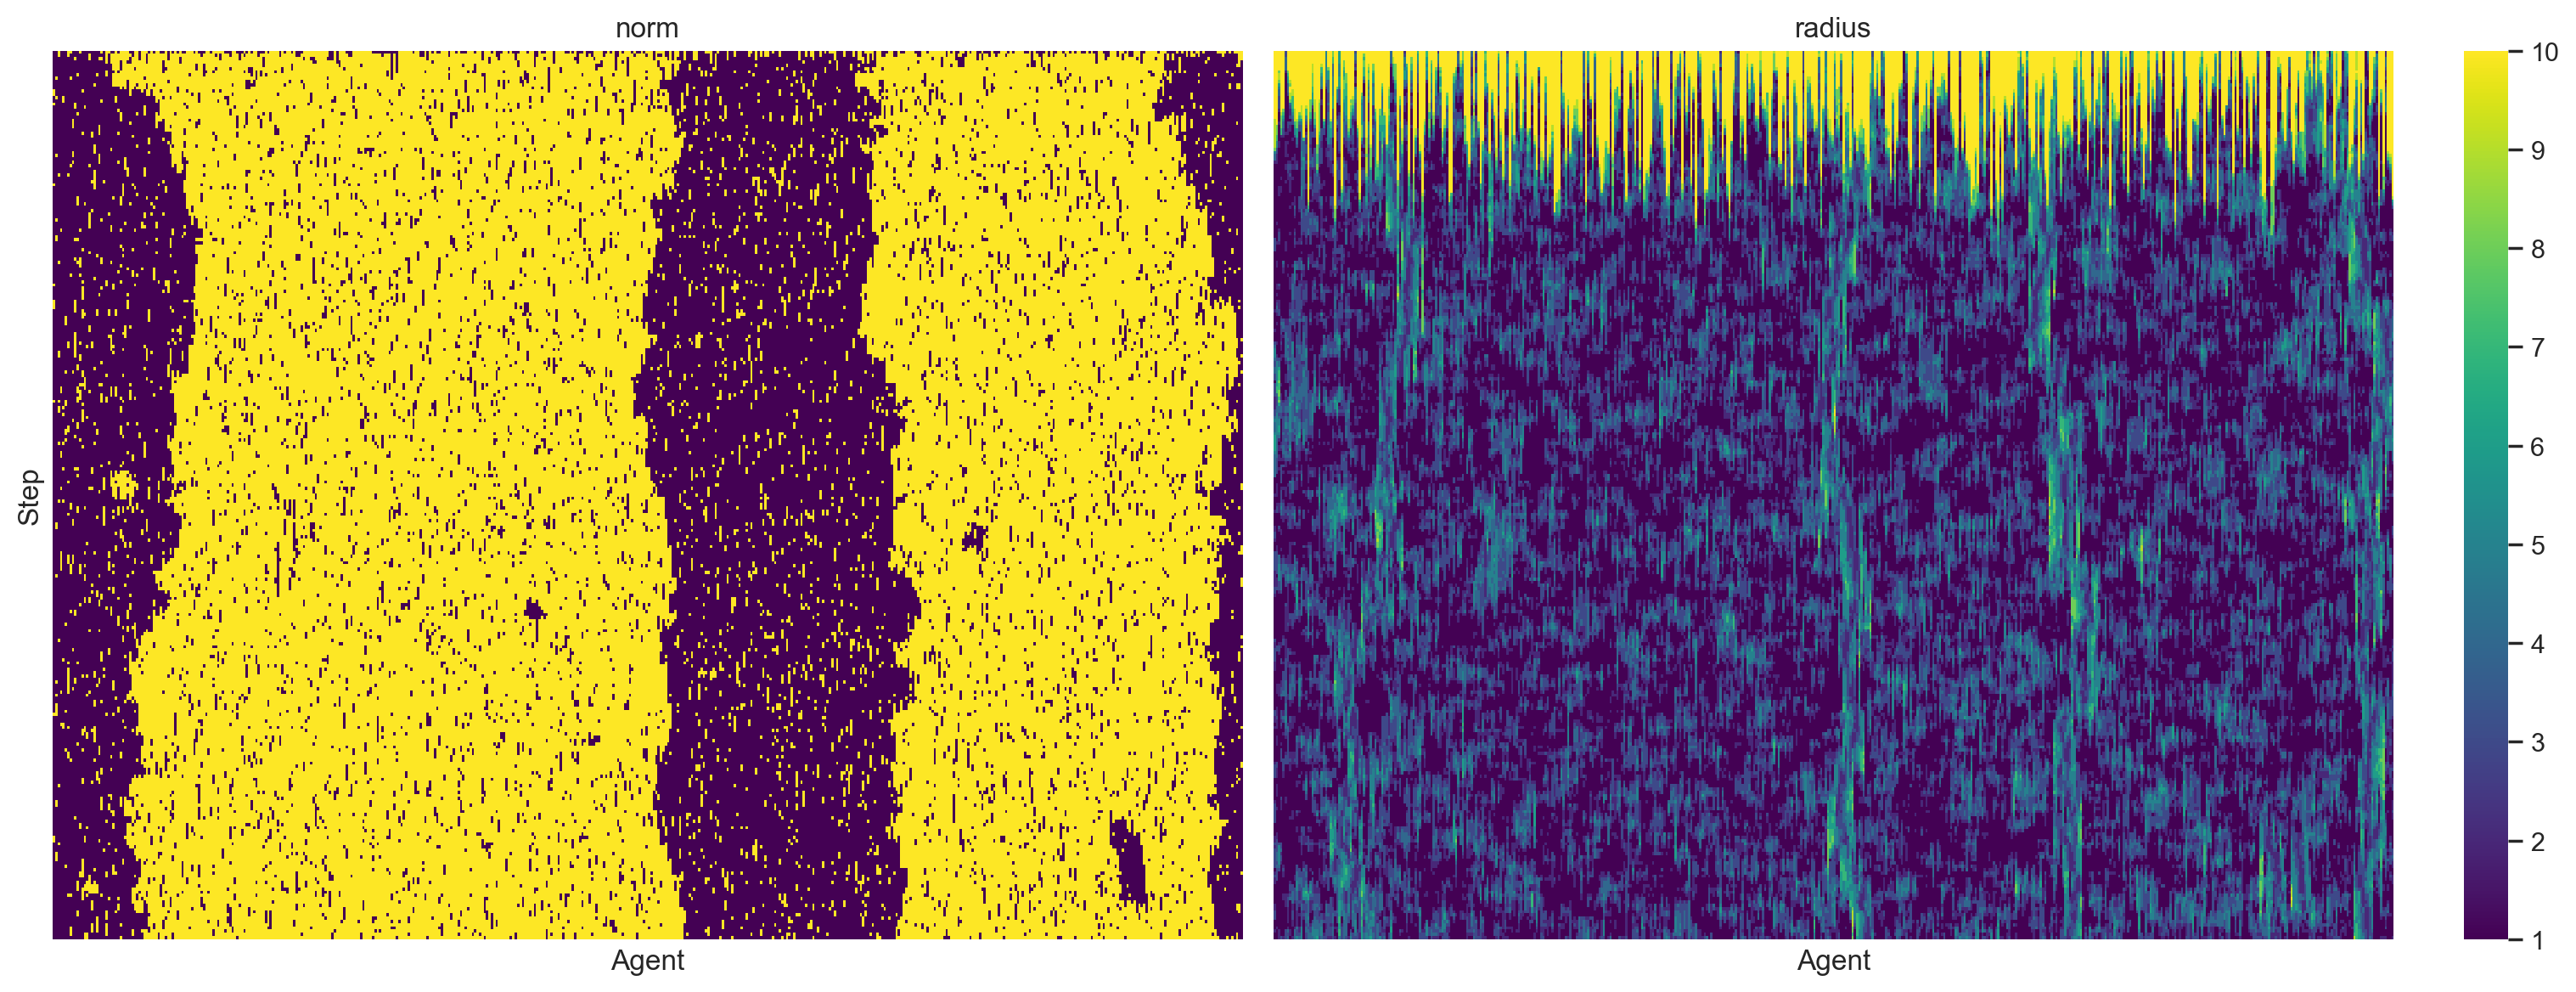

In [27]:
plot_results(model_4);

These results are visually quite interesting but not hugely different from those in previous runs.  For the most part we get two blocks each for each value of norm.  Interestingly, in this case small endogenous dissenting islands occasionally apear inside these blocks and manage to persist for a few timesteps before disappearing.

## Run 5. Higher Noise and Endogenous Neighborhood Norms

The next simulation doubles the noise level from 15% to 30%.

In [28]:
model_5 = simulate(
    ThoughtlessModel(N_AGENT, seed=SEED, noise=0.3,
                     agent_cls=NoisyLazyStatistician),
    N_STEP
)

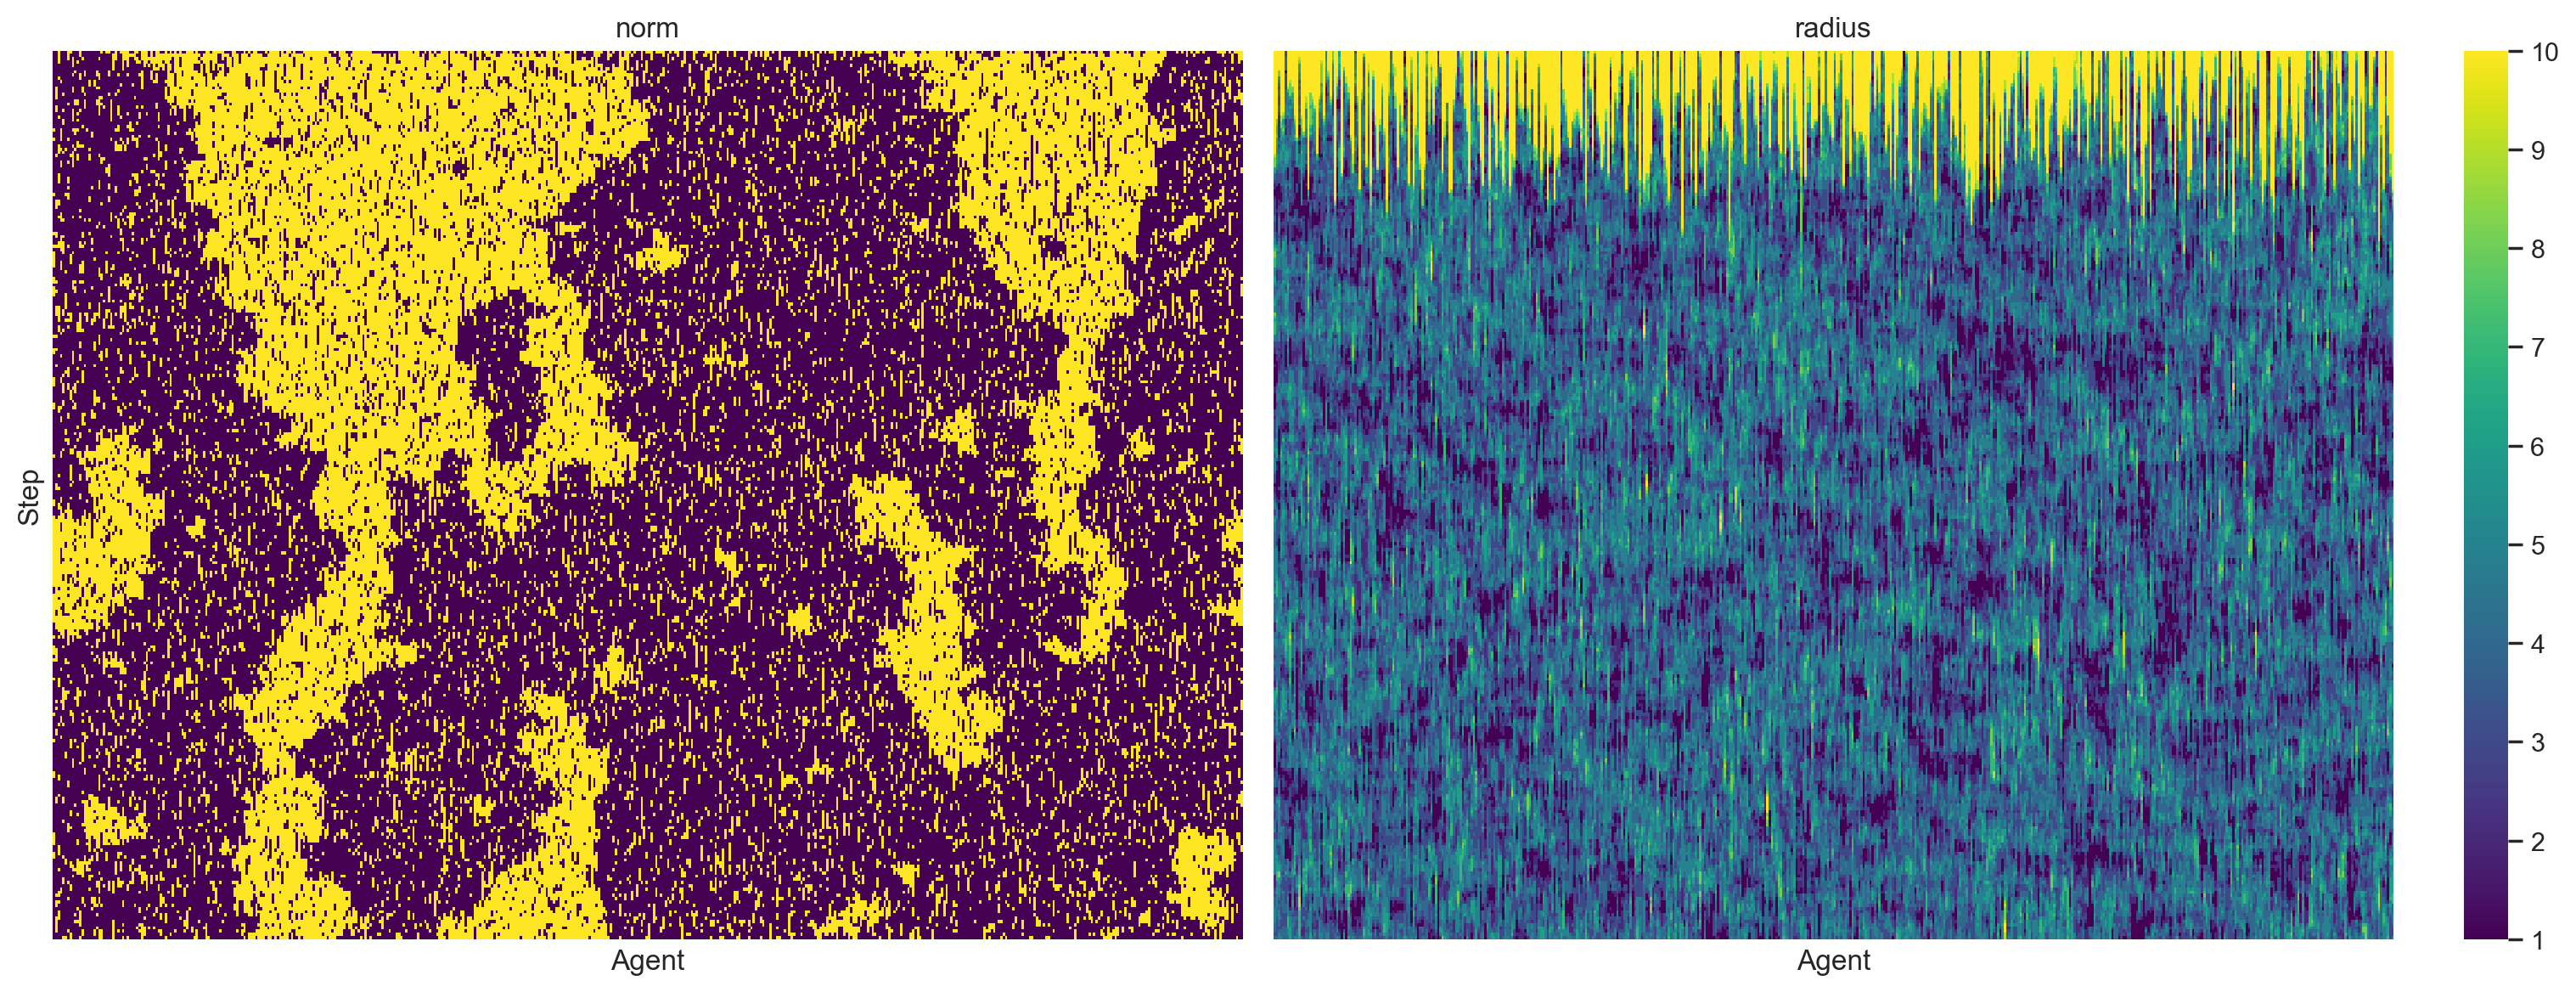

In [29]:
plot_results(model_5);

At this higher noise level, we see the bocks of consistent norm erode over time, and the endognenous islands that appear persist for much longer than in the previous simulation.

## Run 6. Maximum Noise Does Not Induce Maximum Search

In the previous two noisy scenarios, the average agent's radius was consistently higher than in the noiseless scenario, as shown below.

In [30]:
def get_average_radius(model, steps=None):
    return (model.datacollector
                 .get_agent_vars_dataframe()
                 ["radius"]
                 .groupby(level="Step")
                 .mean())

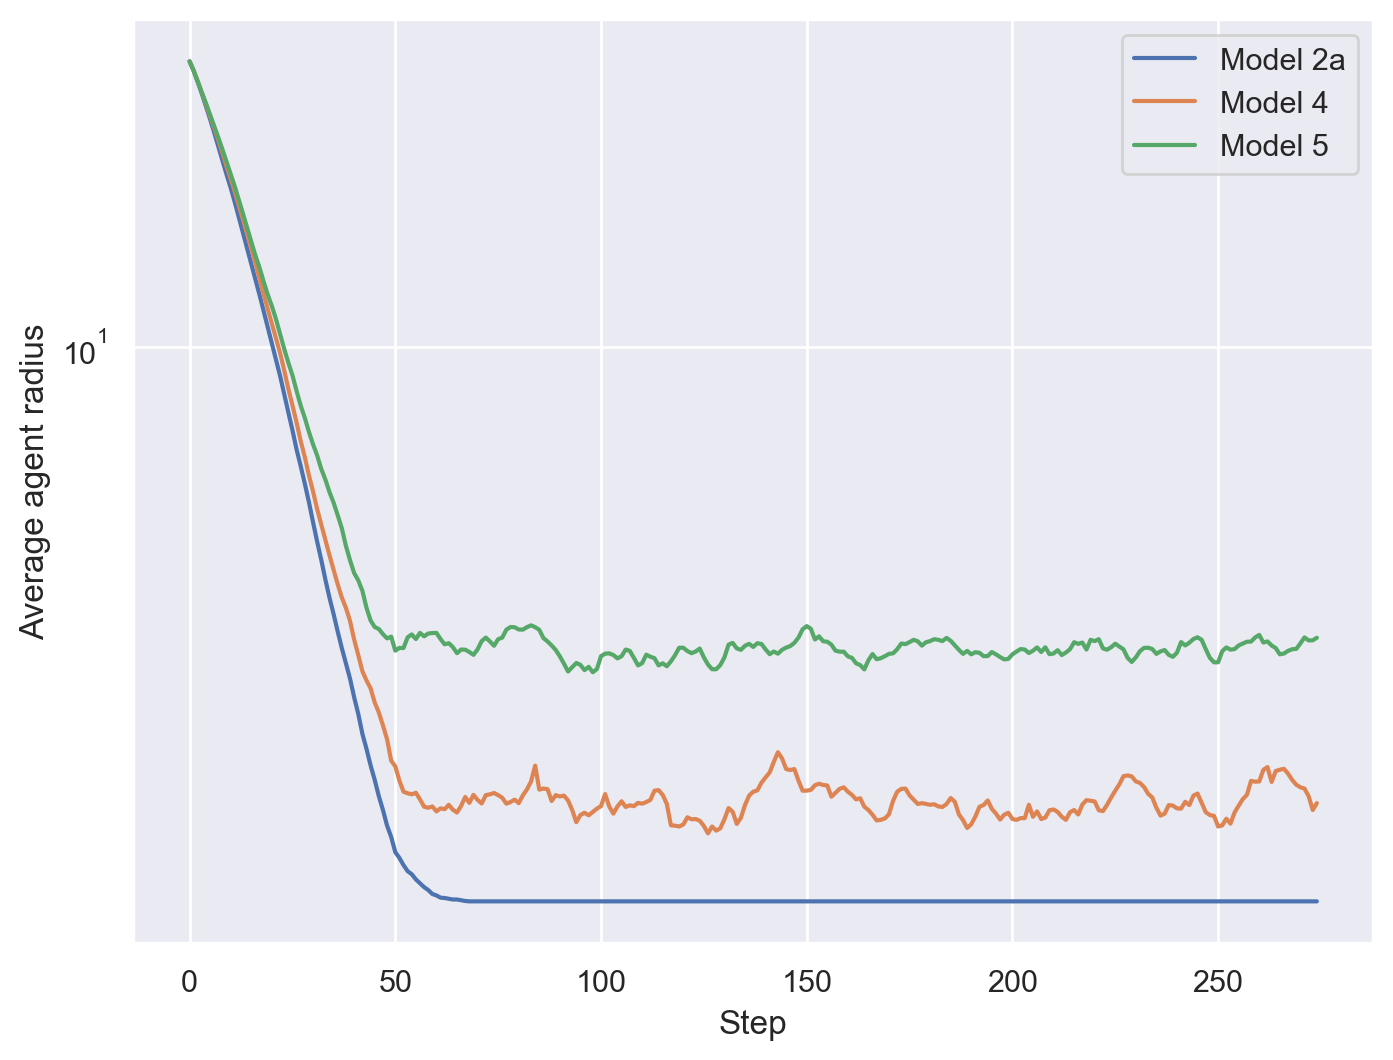

In [31]:
fig, ax = plt.subplots()

get_average_radius(model_2a).plot(label="Model 2a", ax=ax);
get_average_radius(model_4).plot(label="Model 4", ax=ax);
get_average_radius(model_5).plot(label="Model 5", ax=ax);

ax.set_yscale("log");
ax.set_ylabel("Average agent radius");

ax.legend(loc="upper right");

This observation prompts the questions: how much does the average radius increase as the noise increases?  Does it increase without bound in the 100% noise case?  We answer these questions in the next simulation.

In [32]:
model_6 = simulate(
    ThoughtlessModel(N_AGENT, seed=SEED, noise=1,
                     agent_cls=NoisyLazyStatistician),
    N_STEP
)

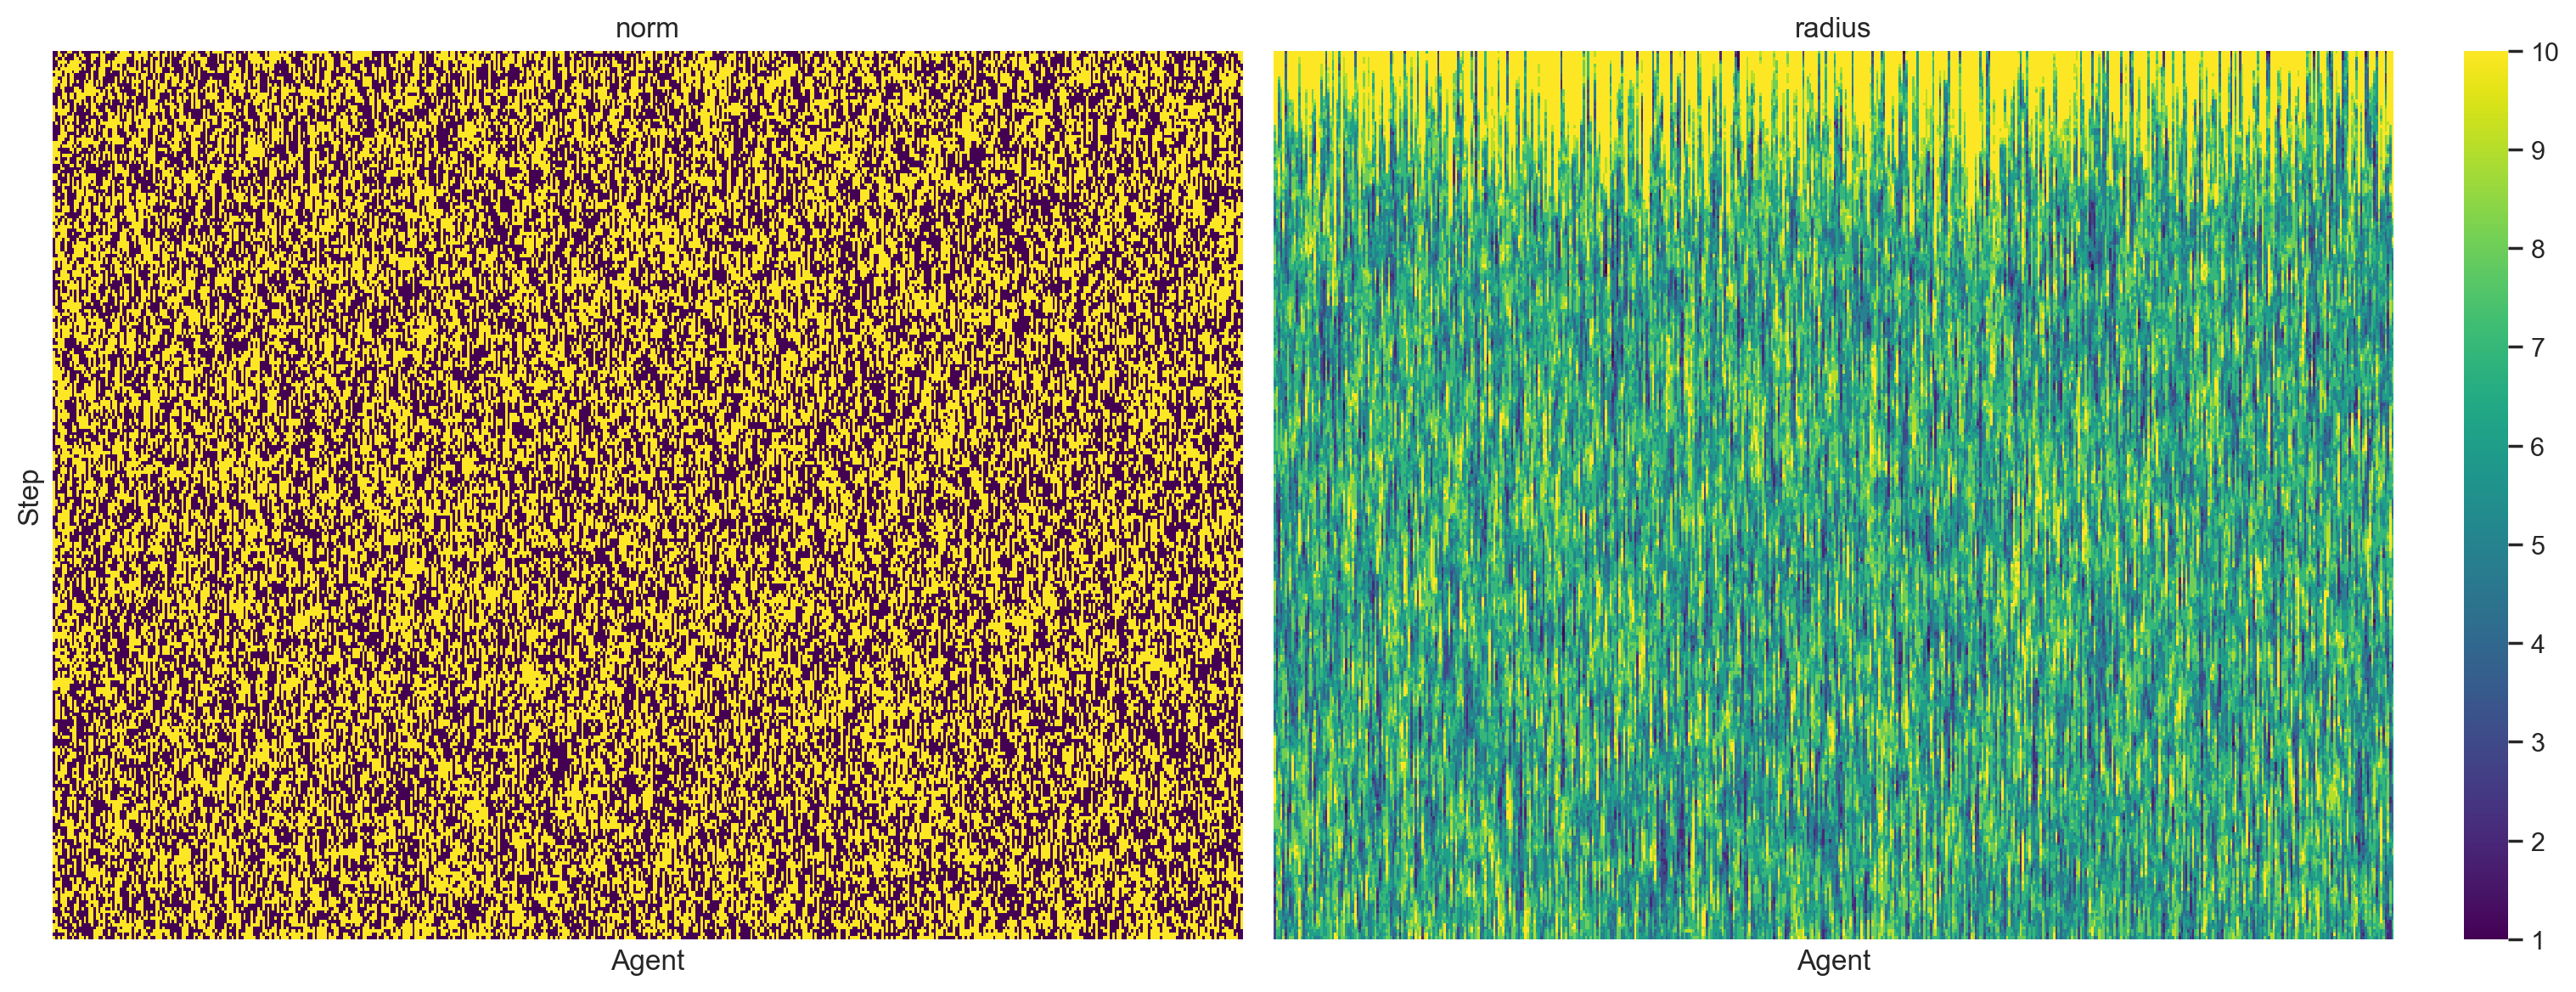

In [33]:
plot_results(model_6);

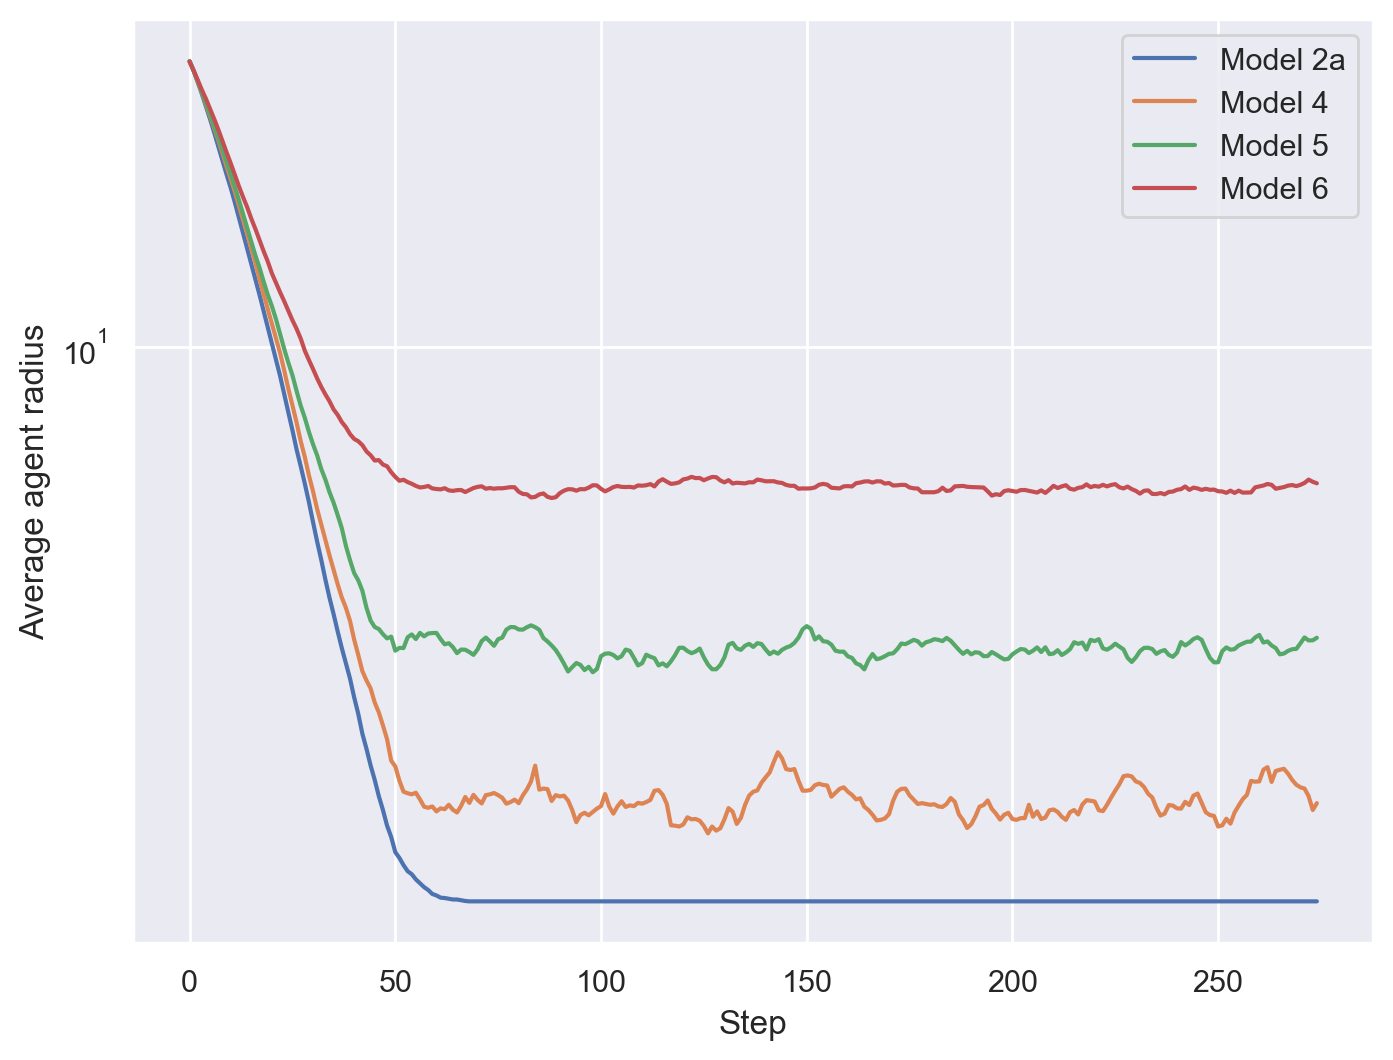

In [34]:
fig, ax = plt.subplots()

get_average_radius(model_2a).plot(label="Model 2a", ax=ax);
get_average_radius(model_4).plot(label="Model 4", ax=ax);
get_average_radius(model_5).plot(label="Model 5", ax=ax);
get_average_radius(model_6).plot(label="Model 6", ax=ax);

ax.set_yscale("log");
ax.set_ylabel("Average agent radius");

ax.legend(loc="upper right");

We see that the average radius does not increase without bound even with maximum noise, which is interesting.

## Run 3. Complacency in New Norm

Finally we return to run three from the paper, which we have deferred until after the noisy scenarios for implementation reasons.  In this run, most of the time our agents behave noiselessly, but for ten time steps for $130 \leq t < 140$ the system experiences a "shock" which causes each agent to behave completely randomly.  We first implement this behavior in the `ShockedLazyStatistician` subclass of `NoisyLazyStatistician`.

In [35]:
class ShockedLazyStatistician(NoisyLazyStatistician):
    def __init__(self, unique_id, model, norm=None, radius=None, noise=0, is_shock=None):
        super().__init__(unique_id, model, norm=norm, radius=radius, noise=noise)

        self.is_shock = (lambda _: False) if is_shock is None else is_shock

    def update_norm(self):
        super().update_norm(noise=1 if self.is_shock(self.model.schedule.time) else None)

We now simulate this scenario and visualize the results.

In [36]:
model_3a = simulate(
    ThoughtlessModel(N_AGENT, seed=SEED, noise=0,
                     is_shock=lambda step: 130 <= step < 140,
                     agent_cls=ShockedLazyStatistician),
    N_STEP
)

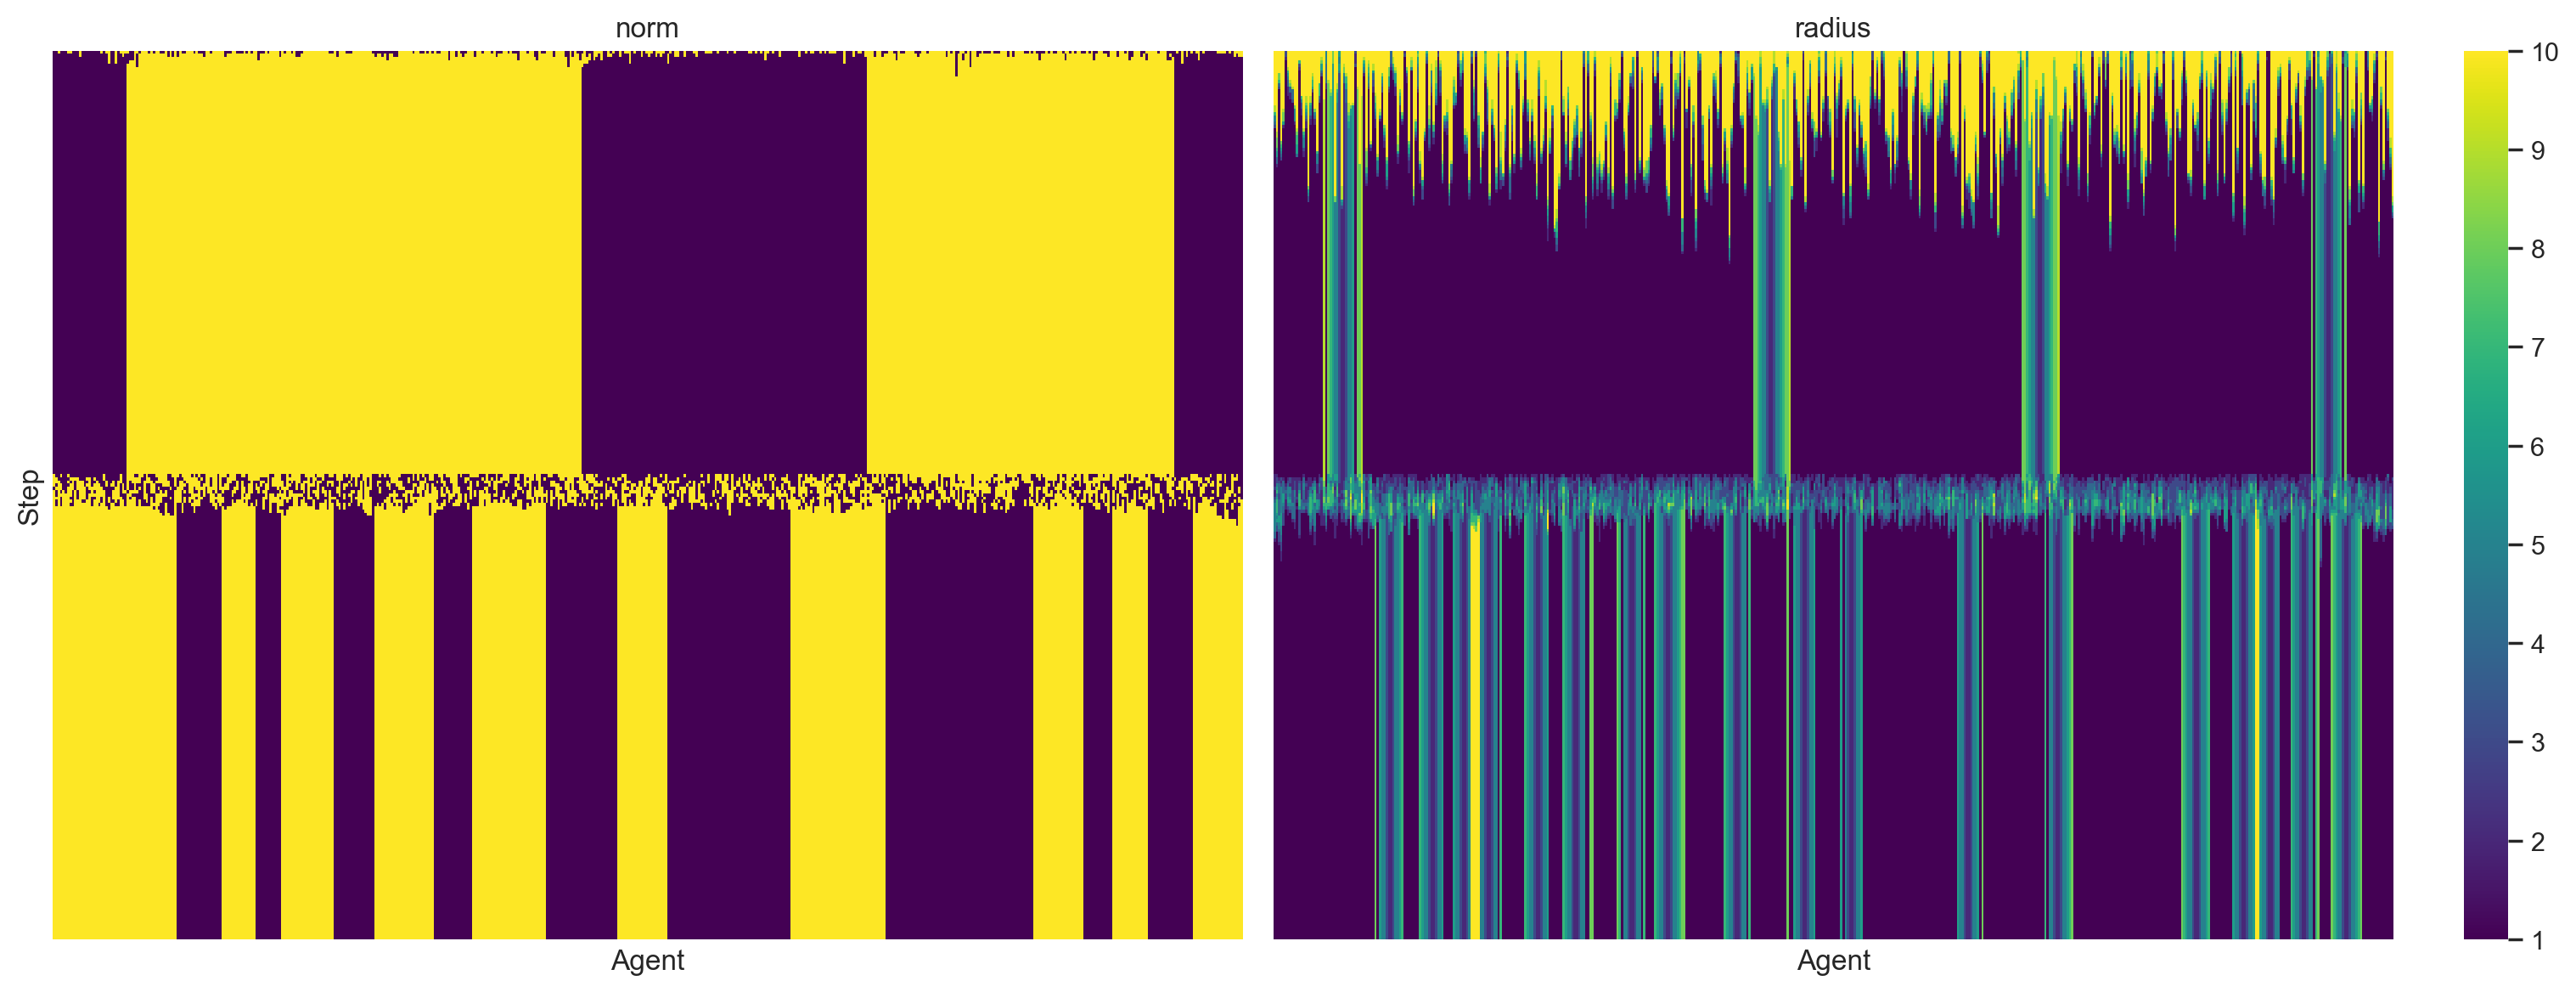

In [37]:
plot_results(model_3a);

Quite interestingly, many new blocks of consistent norm appear almost immediately after the shock subsides.  This behavior is likely due to the fact that an agent's radius cannot increase all that much during the ten time step shock (as was shown in run five.)  This explanation is consistent the the following plot of average agent radius over time.

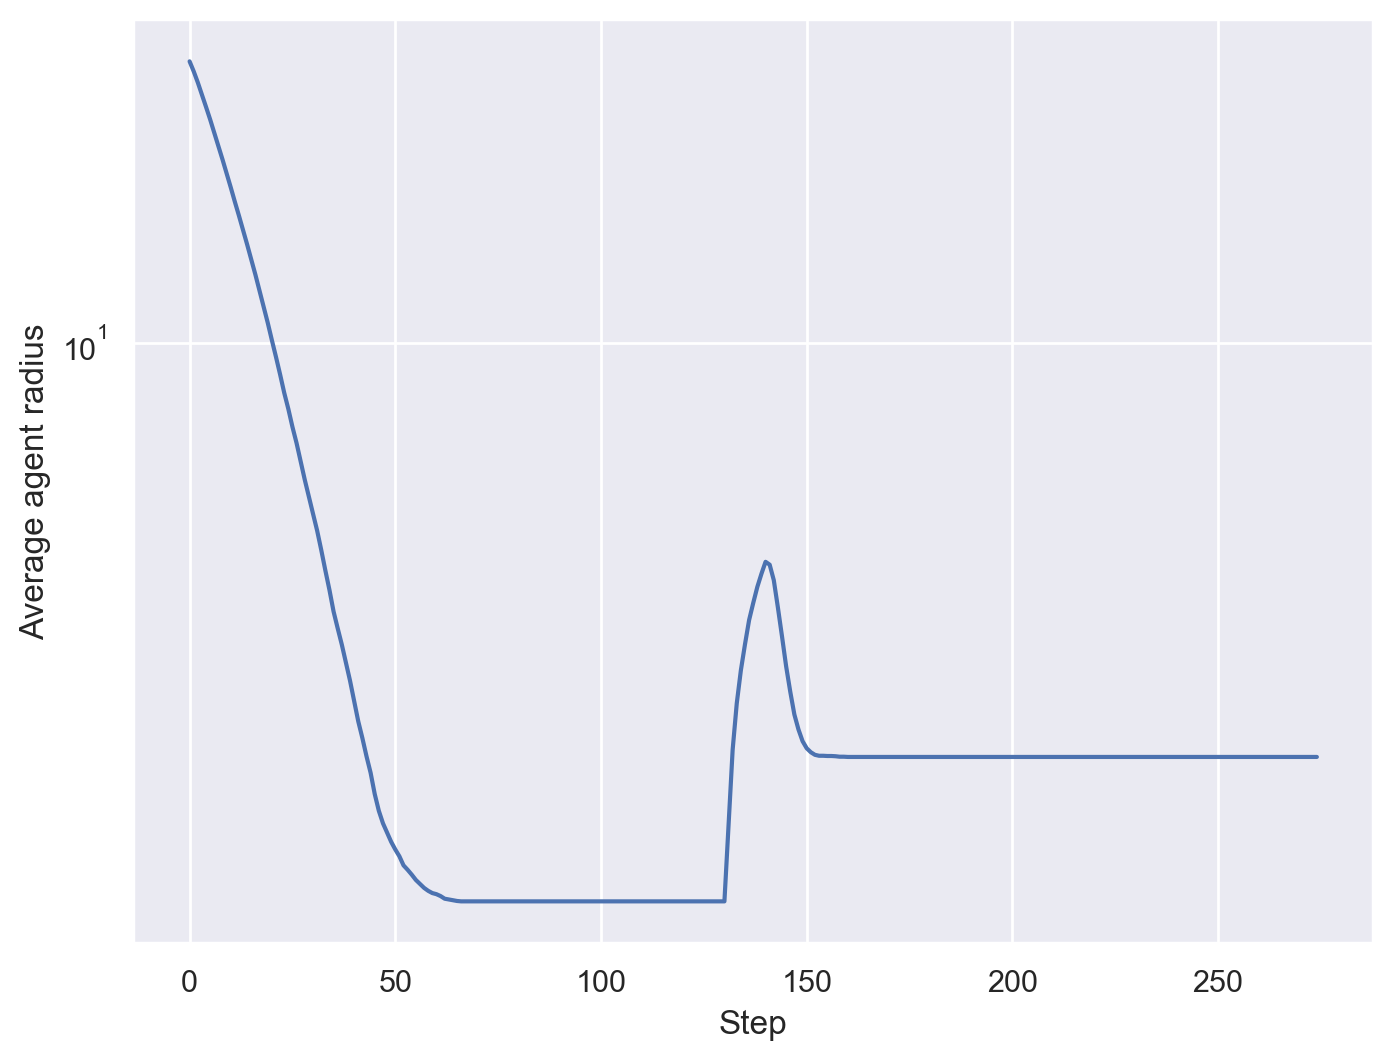

In [38]:
ax = get_average_radius(model_3a).plot()

ax.set_yscale("log");
ax.set_ylabel("Average agent radius");

Though not present in the paper, we consider two additional scenarios.  The first is adding low-level noise (15%) to all time steps in the above scenario.

In [39]:
model_3b = simulate(
    ThoughtlessModel(N_AGENT, seed=SEED, noise=0.15,
                     is_shock=lambda step: 130 <= step < 140,
                     agent_cls=ShockedLazyStatistician),
    N_STEP
)

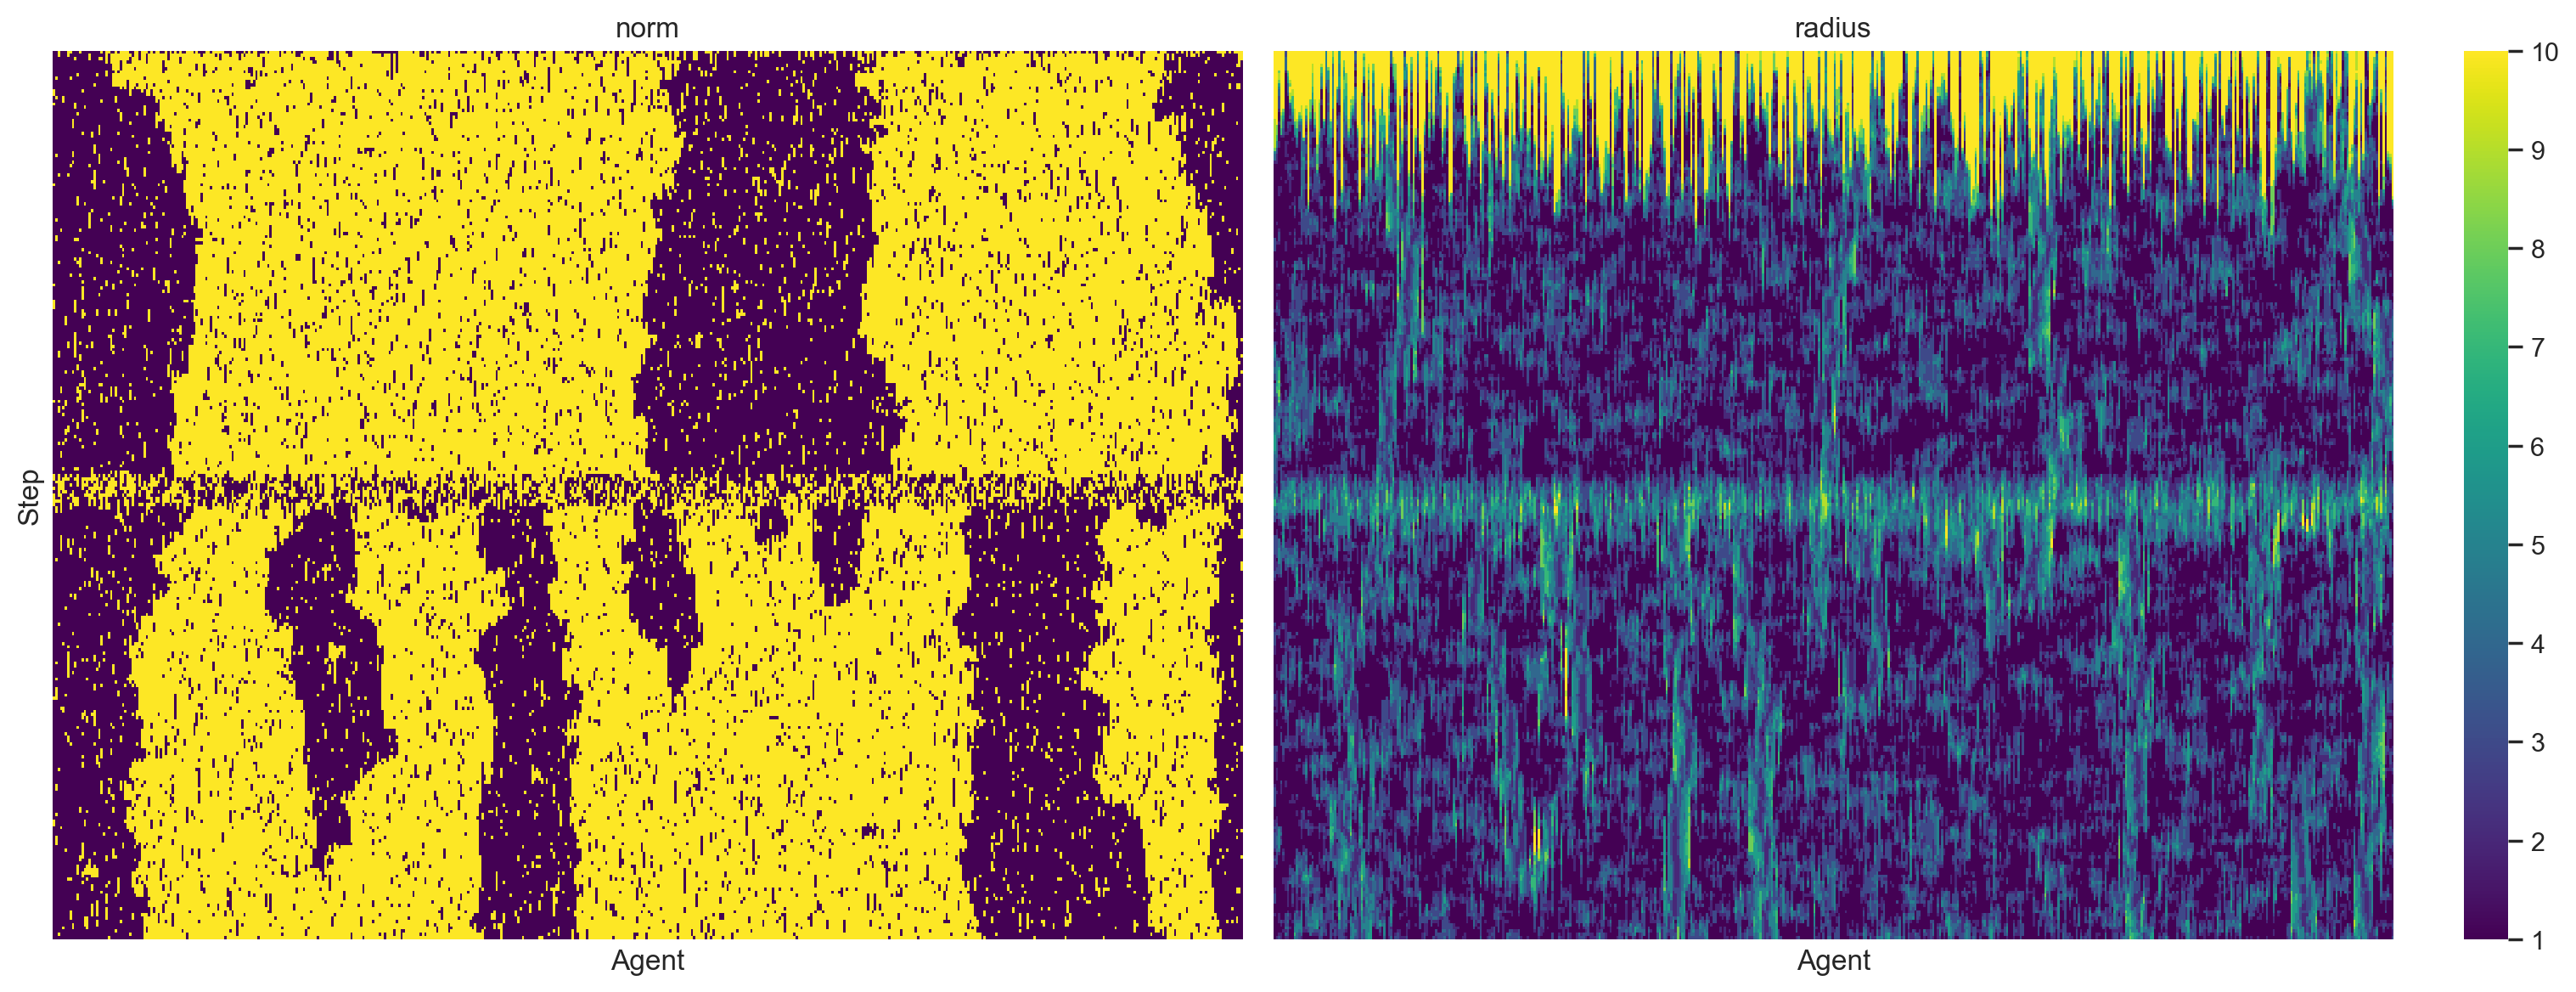

In [40]:
plot_results(model_3b);

The results are not surprising given the outcomes of models 3a and 4.

For our last scenario we maintain this noise level, but increase the number of steps by a factor of ten and shock the system whenever $130 \leq t \operatorname{mod} 275 < 140.$

In [41]:
model_3c = simulate(
    ThoughtlessModel(N_AGENT, seed=SEED, noise=0.15,
                     is_shock=lambda step: 130 <= step % N_STEP < 140,
                     agent_cls=ShockedLazyStatistician),
    10 * N_STEP
)

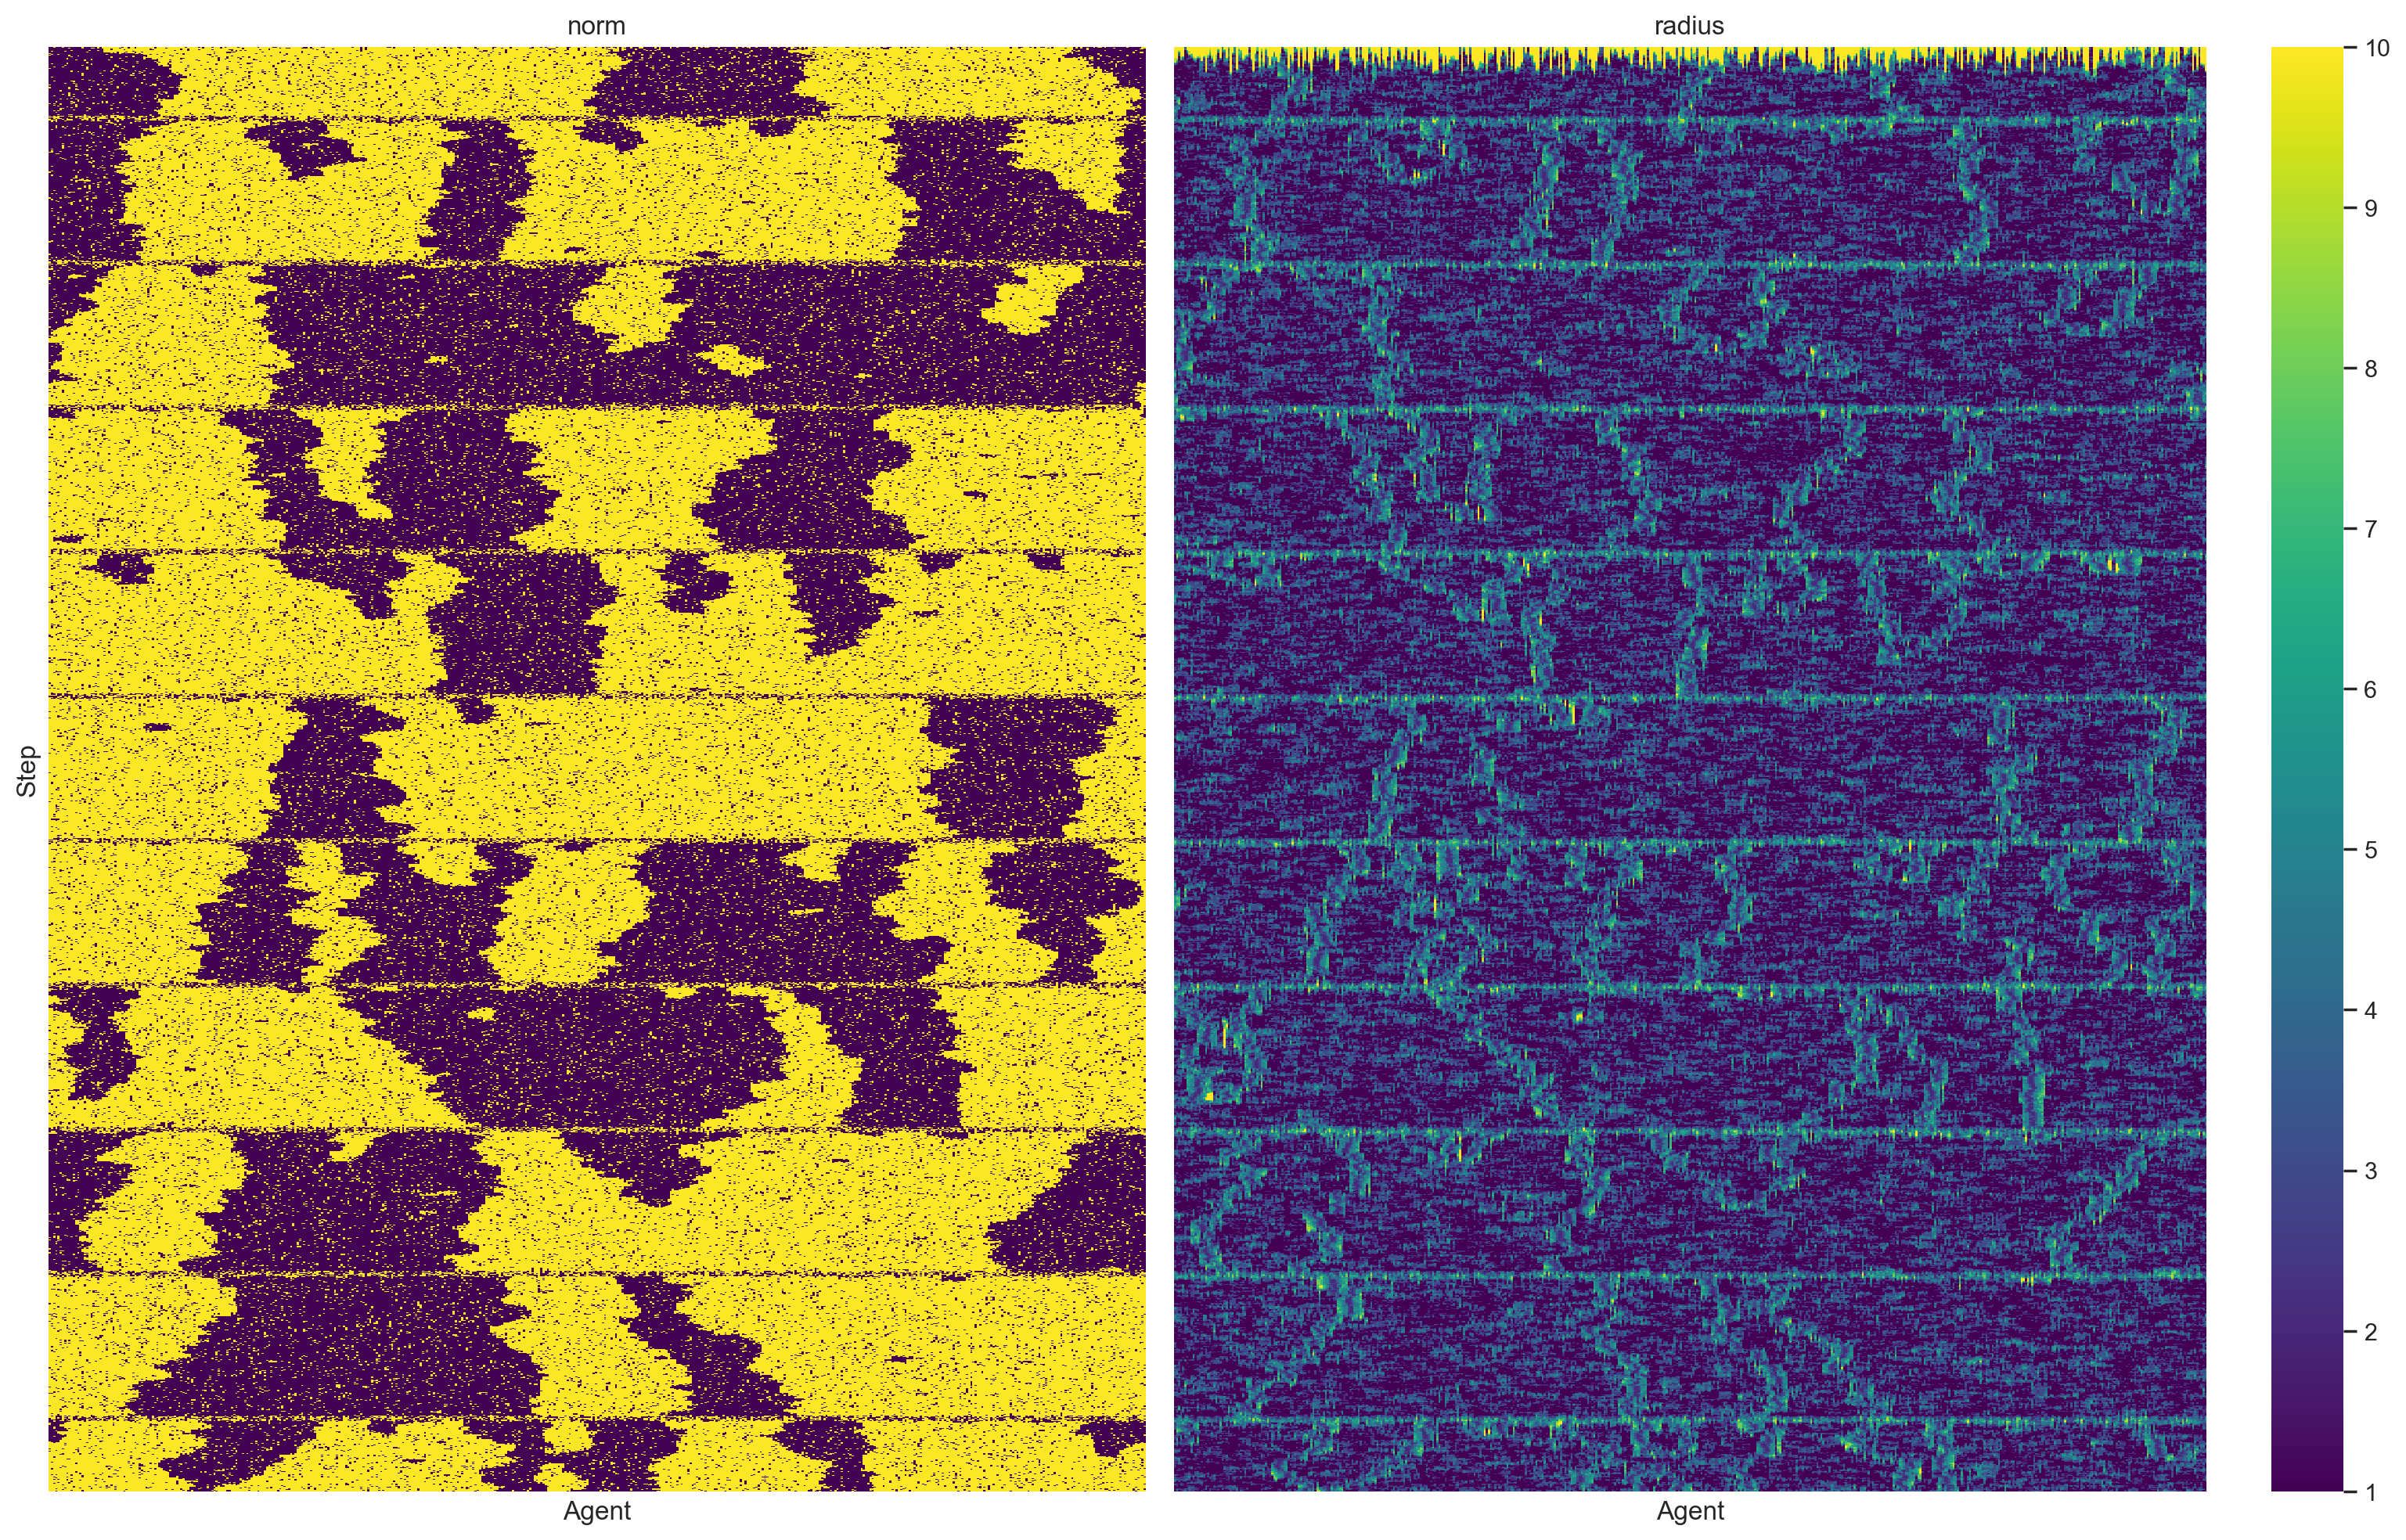

In [42]:
plot_results(model_3c, figsize=(16, 10));

The results are quite fascinating but not unexpected.

We have now reproduce all of the scenarios from Epstein's [_Learning To Be Thoughtless:
Social Norms And Individual Computation_](https://www.brookings.edu/wp-content/uploads/2016/06/thoughtless.pdf).  The behavior of these models is quite interesting and I certainly learned quite a bit about agent-based modeling using Mesa.

This post is available as a Jupyter notebook [here](https://nbviewer.org/gist/AustinRochford/ab03abe5f4157fa9c479be9d2f2bd3f6).

In [43]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Fri Oct 07 2022

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.4.0

seaborn   : 0.11.2
matplotlib: 3.5.3
mesa      : 1.0.0

